<a href="https://colab.research.google.com/github/IzadoraSC/00_vegetation_data/blob/main/Analise_Orientada_A_Objeto_AOO_pt_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANÁLISE ORIENTADA A OBJETO - AOO
1. Obtenção dos dados (utilizando GEE):
  - Selecionar área de estudo;
  - Obtendo dados multiespectrais;
  - Índices de vegetação (NDVI);
  - Dados de elevação;
  - Exportação do cubo de dados.

2. Segmentação e Classificação utilizando RSGISLib e Sckit-Learning (Random Forest);
  
  2.1 **Segmentação** utilizando *RSGISLib Image Segmentation Module*, o  algoritmo de segmentação de Shepherd et al. (2019).

  2.2 **Classificação** utilizando *Random Forest*, algoritmo da biblioteca *Scikit-Learn*

  2.3 Análise da Classificação (Matriz de confusão e Acurácia);

4. Análises: Correlação, PCA, etc.;

5. Referências.


Script By: Izadora S. de Carvalho.

Paper: Izadora S. de Carvalho, Swanni T. Alvarado, Paulo Henrique Alves Leão, Patrick Costa Silva, Tiago Massi Ferraz.

Obs: O código pode ser aplicado para outras áreas de estudos, estamos aberto a colaborações e sugestões.

Contato: izadoraflorestal@gmail.com

Repositório para disponibilização e manutenção de código:

## Conectando Google Drive

In [2]:
# Conectando Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1   Obtendo dados do Google Earth Engine (GEE).
Obtendo as imagens/rasters que serão utilizados nas etapas de segmentação e classificação:
  - Dados Landsat
  - Dados de elevação
  - Índice espectral
---


### Instalando bibliotecas

In [ ]:
# Instalando bibliotecas
#!pip install geemap -q
!pip install -q geopandas
#!pip install -q geobr
#!pip install descartes
!pip install rasterio -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 64.3 MB/s eta 0:00:00


### Importar as bibliotecas

In [ ]:
# Importar as bibliotecas
import geemap
import numpy as np
import geopandas as gpd
#import geobr
import ee
import json
import os
import pandas as pd

import matplotlib.pyplot as plt

#from geobr.read_state import download_gpkg

import rasterio as rio

### Autenticação da conta do GEE

In [1]:
import geemap
import ee

In [2]:
# Autenticação padrão da conta do GEE
#ee.Authenticate()
#ee.Initialize()

# Outras formas de autenticação quando estiver com problemas na forma padrão

## Forma I:
ee.Authenticate()
ee.Initialize(project='ee-izadorasc')  ## 'project' é individual para cada usuário

## Forma II:

#m = geemap.Map()
#m

### Usando geobr (acessar base de dados do IBGE)

In [ ]:
# Lendo vetor do PNCM usando geobr

UCs = geobr.read_conservation_units()
UCs
#BR = geobr.read_country()
#BR
#BR.plot()

In [ ]:
# Selecionando área de interesse
list_of_names = ['PARQUE NACIONAL DA CHAPADA DAS MESAS']
pncm_df = UCs.query('name_conservation_unit in @list_of_names')
pncm_df

In [ ]:
MA = geobr.read_state(code_state='MA', year=2020)
MA

In [ ]:
MA.plot()

In [ ]:
pncm_df.plot()

In [ ]:
#Conversão de geodataframe para json
pncm_json = pncm_df.to_json()

#Carregando o arquivo
pncm_json_coords = json.loads(pncm_json)

# Selecionando coordenadas
pncm_coord = pncm_json_coords['features']

In [ ]:
print(pncm_json_coords)

In [ ]:
pncm_coord

In [ ]:
# Convertendo para FeatureCollection
aoi = ee.FeatureCollection(pncm_coord)

### **Data Image**

#### **Informações sobre os sensores**

In [ ]:
# Reflectância de Superficíe

# Landsat 4 TM (Aug 22, 1982 - Jun 24, 1993)
  # USGS Landsat 4 Level 2, Collection 2, Tier 1
  # sensor = "LANDSAT/LT04/C02/T1_L2"

# Landsat 5 TM (Mar 16, 1984 - May 05, 2012)
  # USGS Landsat 5 Level 2, Collection 2, Tier 1
  # sensor = "LANDSAT/LT05/C02/T1_L2"

# Landsat 7 ETM+ (May 28, 1999 - Jul 15, 2023)
  # USGS Landsat 7 Level 2, Collection 2, Tier 1
  # sensor = "LANDSAT/LE07/C02/T1_L2"

# Landsat 8 OLI (Mar 18, 2013 - present)
  # USGS Landsat 8 Level 2, Collection 2, Tier 1
  # sensor = "LANDSAT/LC08/C02/T1_L2"

# Landsat 9 OLI (Out 31, 2021 - present)
  # USGS Landsat 9 Level 2, Collection 2, Tier 1
  # sensor = "LANDSAT/LC09/C02/T1_L2"

# scale factor = 2.75e-05
# scale factor surface temperature = 0.00341802

##########################################

# Harmonized Sentinel-2 MSI: MultiSpectral Instrument, Level-1C (Jun 23, 2015 - present)
# sensor = "COPERNICUS/S2_HARMONIZED"
# Harmonized Sentinel-2 MSI: MultiSpectral Instrument, Level-2A (Mar 28, 2017 - present)
  # sensor = "COPERNICUS/S2_SR_HARMONIZED"


##########################################
# Julian days
# jan = [1,31,'day_of_year'];
# fev = [32,59,'day_of_year'];
# mar = [60,90,'day_of_year'];
# abr = [91,120,'day_of_year'];
# may = [121,151,'day_of_year'];
# jun = [152,181,'day_of_year'];
# jul = [182,212,'day_of_year'];
# ago = [213,243,'day_of_year'];
# set = [244,273,'day_of_year'];
# out = [274,304,'day_of_year'];
# nov = [304,334,'day_of_year'];
# dez = [335,365,'day_of_year'];

############################################
# Alguns formatos de dados
# .toDouble()  #64-bit float
# .toFloat()  #32-bit float
# .toInt16()  # signed 16-bit integer
# .toInt32() # signed 32-bit integer
# .toUint16() # unsigned 16-bit integer

####Visualização dos dados: Paletas

In [3]:
#Visualização dos dados

# Visualização composição de bandas - Landsat
paletteVisLS457 = {
  'min': 0,
  'max': 0.3,
  'gamma': 1,
  'opacity': 1,
  'bands': ['SR_B5', 'SR_B4', 'SR_B3']}

#'min': 0,
#'max': 0.3,
#'min': 10400,
#'max': 20500,

paletteVisLS89 = {
  'min': 0,
  'max': 0.3,
  'gamma': 1,
  'opacity': 1,
  'bands': ['SR_B6', 'SR_B5', 'SR_B4']}


# Visualização Mask water
paletteVisWater = {
  'min': 0,
  'max': 1,
  #'bands': ['elevation'],
  'palette': ['ffffff', '0000ff']}

# Visualização DEM
paletteVisMDE = {
  'min': 0,
  'max': 610,
  'bands': ['DSM'],
  'palette': ['0000ff', '00ffff', 'ffff00', 'ff0000', 'ffffff']}

paletteVisSRTM = {
  'min': 0,
  'max': 610,
  'bands': ['elevation'],
  'palette': ['0000ff', '00ffff', 'ffff00', 'ff0000', 'ffffff']}

# Índices Landsat - NDVI, NDWI
waterPalette = {
      'min': 0,
      'max': -1,
      'palette': ['red', 'yellow', 'green', 'blue']
      }

paletteVisNDVI_ls = {
  'min': 0,
  'max': 1,
  'palette': ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
               '74A901', '66A000', '529400', '3E8601', '207401', '056201',
               '004C00', '023B01', '012E01', '011D01', '011301']
  }

paletteVisNDWI_ls = {
  'min': -1,
  'max': 0.5,
  'palette': ['red', 'yellow', 'green', 'blue']
  }

#### **Máscara de Nuvens**
- Landsat - TM, OLI

In [5]:
## Landsat 4, 5, 7, 8 and 9 for SR data
def maskLSclouds(image):

  # Os bits 3 e 5 são a sombra da nuvem e a nuvem, respetivamente, para os produtos Landsat 4-5-7-8 e 9 SR
  # Aqui definimos os valores dos bits em valores de bytes.

# Criando uma função para mascarar pixéis de nuvens e sombras de nuvens
# 1 corresponde a céu limpo
# 3 corresponde a sombra de nuvem
# 5 corresponde a nuvem

  #cloudShadowBitMask = ee.Number(1).pow(3).int()
  #cloudsBitMask = ee.Number(1).pow(5).int()
  qaMask = image.select('QA_PIXEL').bitwise_and(int('11111', 2)).eq(0)
  saturationMask = image.select('QA_RADSAT').eq(0)

  # Obter a banda de pixel QA da coleção.
  #qa = image.select('QA_PIXEL')

  ###Fator de escala
  #opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)

  ###Fator de escala
  opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)

  ##Produto resultante
  return image.addBands(opticalBands, None, True)\
  .addBands(thermalBands, None, True).updateMask(qaMask)\
  .updateMask(saturationMask)


  # Se esse processo não for realizado, não podemos filtrar por data depois.
  #return image.updateMask(mask.copyProperties(image,["system:time_start"]))

#### **Imagens Landsat**

In [6]:
## Define the Region of Interest (ROI)
ROI = ee.Geometry.Rectangle([-47.48, -6.85, -46.70, -7.42])
#ROI2 = ee.FeatureCollection("projects/ee-izadorasc/assets/limite_pncm")

# Define the Landsat sensor collection
# Choose the desired sensor and date range here

#sensor = "LANDSAT/LT05/C02/T1_L2"
sensor = "LANDSAT/LC08/C02/T1_L2"

# Date range
#date_range = ['1984-01-01', '1985-12-31']
#date_range = ['1995-01-01', '1995-12-31']
#date_range = ['2005-01-01', '2005-12-31']
#date_range = ['2015-01-01', '2015-12-31']
#date_range = ['2020-01-01', '2020-12-31']
date_range = ['2022-01-01', '2022-12-31']


# Load Landsat surface reflectance data
sr_collection = ee.ImageCollection(sensor) \
    .filterBounds(ROI)\
    .filter(ee.Filter.lt('CLOUD_COVER', 1))\
    .filterDate(date_range[0], date_range[1])

# Define wet and dry season subsets

wet_season = [1, 181, 'day_of_year']  # Jan - Jun
dry_season = [182, 304, 'day_of_year']  # Jul - Oct

wet = sr_collection.filter(ee.Filter.calendarRange(wet_season[0], wet_season[1], wet_season[2]))
dry = sr_collection.filter(ee.Filter.calendarRange(dry_season[0], dry_season[1], dry_season[2]))

# Map the maskLSclouds function over each seasonal dataset and take the median of clear pixels.
wet_comp = wet.map(maskLSclouds).median()
dry_comp = dry.map(maskLSclouds).median()

# Clip the composite images to the Region of Interest
clip_wet_comp = wet_comp.clip(ROI)
clip_dry_comp = dry_comp.clip(ROI)

# Display composite results using geemap
Map = geemap.Map(center=[-7.135, -47.09], zoom=10)

# Add the wet and dry season composites to the map

# LS4 LS5 and LS7
# Map.addLayer(clip_wet_comp, paletteVisLS457, 'Wet_composite')
# Map.addLayer(clip_dry_comp, paletteVisLS457, 'Dry_composite')

# LS8 and LS9
Map.addLayer(clip_wet_comp, paletteVisLS89, 'Wet_composite')
Map.addLayer(clip_dry_comp, paletteVisLS89, 'Dry_composite')


# Display the map
Map.addLayerControl()
Map  # This will display the map in the Jupyter notebook.


Map(center=[-7.135, -47.09], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [7]:
# Mapa comparativo - wet season and dry season

# LS4 LS5 and LS7
# left_layer = geemap.ee_tile_layer(clip_wet_comp, paletteVisLS457, 'Wet_composite')
# right_layer = geemap.ee_tile_layer(clip_dry_comp, paletteVisLS457, 'Dry_composite')

# LS8 and LS9
left_layer = geemap.ee_tile_layer(clip_wet_comp, paletteVisLS89, 'Wet_composite')
right_layer = geemap.ee_tile_layer(clip_dry_comp, paletteVisLS89, 'Dry_composite')


Map = geemap.Map(center=[-7.1,-47], zoom=10) #maranhão

Map.split_map(left_layer, right_layer)
Map

Map(center=[-7.1, -47], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

#####Download

In [ ]:
###### Download da imagem
###### Exportando Composição para o Google Drive

## Exportando a image da estação chuvosa, especificando a escala, região, sistema de coordenada.

#image= clip_wet_comp.select('SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7'),  ##LS5
#image= clip_wet_comp.select('SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7'),  ##LS8

task = ee.batch.Export.image.toDrive(
            image= clip_wet_comp.select('SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7'),
            description= "Wet_season_composite_PNCM-2022",
            folder= "00_vegetation_data",
            region= ROI.getInfo()["coordinates"], # conversão necessária para recortar o raster de saída
            scale= 30, ## tamanho do pixel em metros
            crs= "EPSG:4326", #WGS84 - World Geodetic System 1984
            fileFormat= "GeoTIFF",
            maxPixels= 5000000000) # Definir um valor muito grande para garantir que toda a imagem seja exportada

task.start()

task = ee.batch.Export.image.toDrive(
            image= clip_dry_comp.select('SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7'),
            description= "Dry_season_composite_PNCM-2022",
            folder= "00_vegetation_data",
            region= ROI.getInfo()["coordinates"], # conversão necessária para recortar o raster de saída
            scale= 30, ## tamanho do pixel em metros
            crs= "EPSG:4326", #WGS84 - World Geodetic System 1984
            fileFormat= "GeoTIFF",
            maxPixels= 5000000000) # Definir um valor muito grande para garantir que toda a imagem seja exportada

task.start()

### **Mask Water**

In [8]:
## Define the Region of Interest (ROI)

ROI = ee.Geometry.Rectangle([-47.48, -6.85, -46.70, -7.42])

#Carregando máscara

mask_river = ee.Image("projects/ee-izadorasc/assets/mask_river")

mask_clip = mask_river.clip(ROI)

#mask_reclass = mask_clip.remap([1,0],[0,1])


# Display composite results using geemap
Map = geemap.Map(center=[-7.135, -47.3], zoom=11)

# Mask
#Map.addLayer(w_rem.updateMask(w_mask.neq(1)), paletteVisWater, "Water Cover")
Map.addLayer(mask_clip, paletteVisWater, "Water Cover")
#Map.addLayer(mask_reclass, paletteVisWater, "Water Cover")

# Display the map
Map.addLayerControl()
Map  # This will display the map in the Jupyter notebook.

Map(center=[-7.135, -47.3], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

In [ ]:
task = ee.batch.Export.image.toDrive(
            image= mask_reclass,
            description= "mask_water",
            folder= "00_vegetation_data",
            region= ROI.getInfo()["coordinates"], # conversão necessária para recortar o raster de saída
            scale= 30, ## tamanho do pixel em metros
            crs= "EPSG:4326", #WGS84 - World Geodetic System 1984
            fileFormat= "GeoTIFF",
            maxPixels= 5000000000) # Definir um valor muito grande para garantir que toda a imagem seja exportada

task.start()

### **Dados de Elevação**

In [9]:
# Definindo região de interesse (ROI)
ROI = ee.Geometry.Rectangle([-47.48, -6.85, -46.70, -7.42])
#ROI = ee.FeatureCollection("projects/ee-izadorasc/assets/limite_pncm")

#ALOS
alos = "JAXA/ALOS/AW3D30/V3_2"
mde_data = ee.ImageCollection(alos)
elevation = mde_data.select('DSM')

# SRTM
srtm = ee.Image('USGS/SRTMGL1_003')
mde_srtm = srtm.select('elevation')

# Função para recortar cada imagem na coleção
def clip_image(image):
    return image.clip(ROI)

# Recorte da imagem
alos_dsm = elevation.map(clip_image)
srtm_dem = mde_srtm.clip(ROI)

# Reduzindo a uma image
alos_dsm_v2 = alos_dsm.select('DSM').median()
alos_dsm_v2

# Display composite results using geemap
Map = geemap.Map(center=[-7.135, -47.09], zoom=10)

# MDE
Map.addLayer(alos_dsm_v2, paletteVisMDE, 'DSM - Alos')
Map.addLayer(srtm_dem, paletteVisSRTM, 'DEM - SRTM')


# Display the map
Map.addLayerControl()
Map  # This will display the map in the Jupyter notebook.

Map(center=[-7.135, -47.09], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [ ]:
# Mapa comparativo - Alos e SRTM

left_layer = geemap.ee_tile_layer(alos_dsm_v2, paletteVisMDE, 'DSM - Alos')
right_layer = geemap.ee_tile_layer(srtm_dem, paletteVisSRTM, 'DEM - SRTM')

Map = geemap.Map(center=[-7.1,-47], zoom=10) #maranhão

Map.split_map(left_layer, right_layer)
Map

Map(center=[-7.1, -47], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

####Download

In [ ]:
# Export.image.toDrive(clipped, 'Alos_30m_pncm','GeoTIFF', )

### Alos
task_wet = ee.batch.Export.image.toDrive(
    image=alos_dsm.select('DSM').median().int16(),
    description='AlosV32median_30m_pncm',
    folder='00_vegetation_data',
    crs= "EPSG:4326",
    scale=30,  # tamanho do pixel em metros
    region=ROI.getInfo()["coordinates"],
    fileFormat= "GeoTIFF",
    maxPixels= 10000000000000
)
task_wet.start()

### SRTM
task_wet = ee.batch.Export.image.toDrive(
    image=srtm_dem,
    description='SRTM_30m_pncm',
    folder='Landsat_composite',
    crs= "EPSG:4326",
    scale=30,  # tamanho do pixel em metros
    region=ROI.getInfo()["coordinates"],
    fileFormat= "GeoTIFF",
    maxPixels= 10000000000000
)

task_wet.start()

##### Diferença entre dados Alos (DSM) e dados SRTM (DEM)

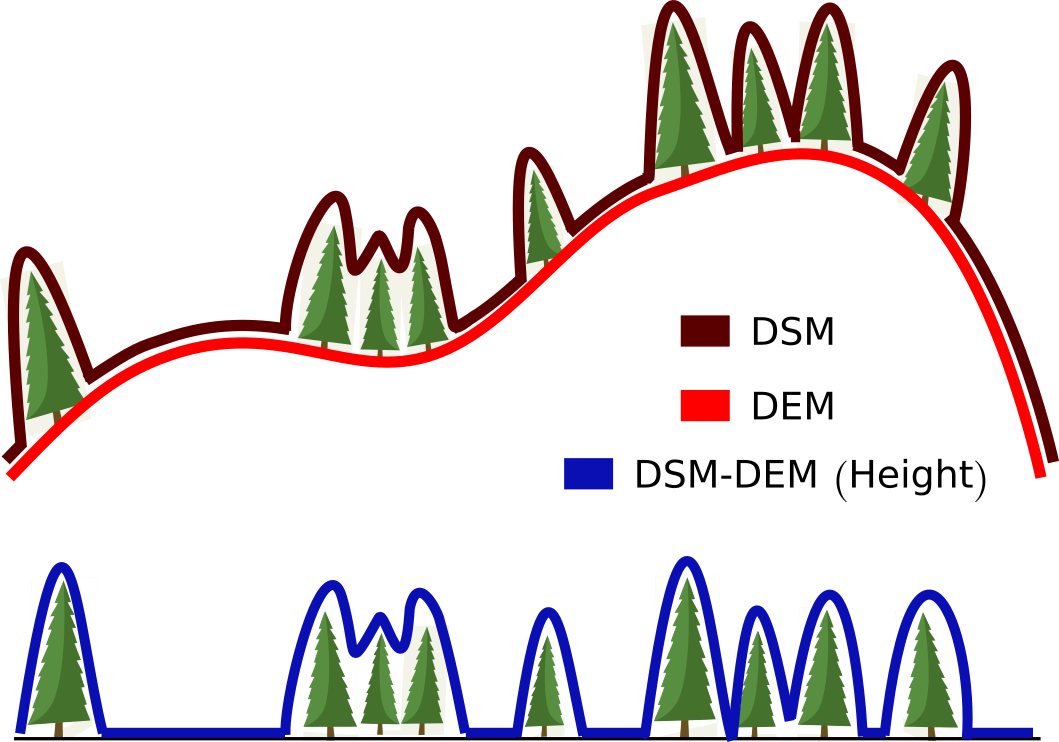

### **Índices de Vegetação**

#### Landsat 5 Bands

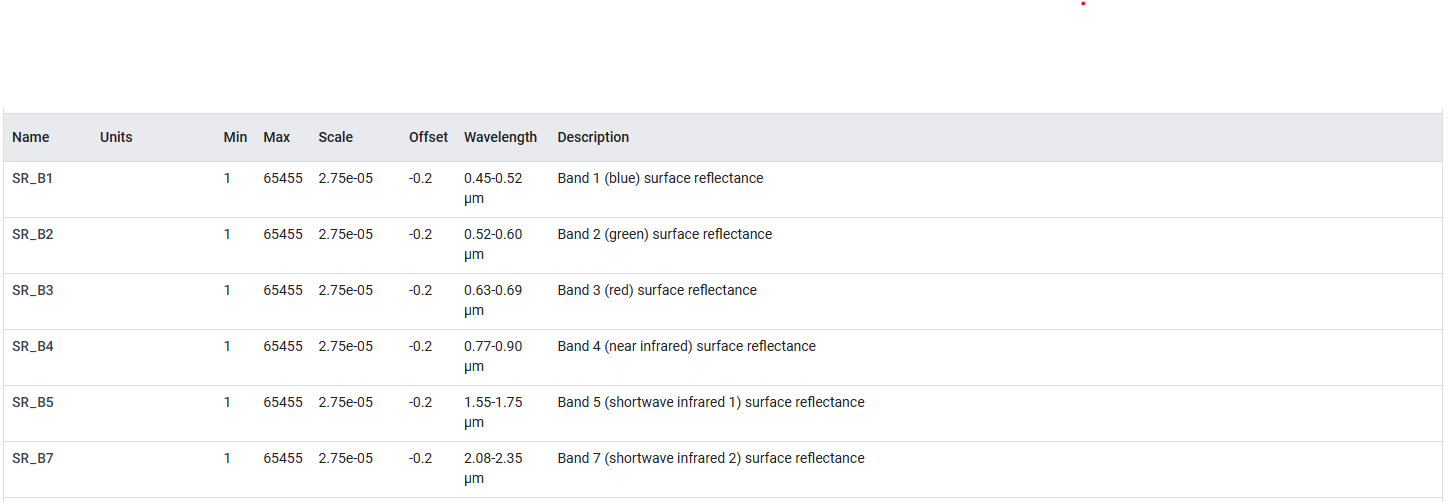

#### Landsat 8 and 9 (sensor OLI) Bands

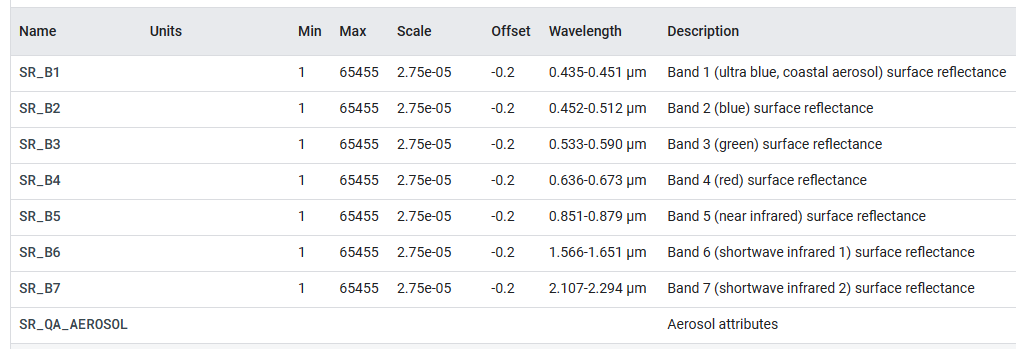

#### Cálculo dos Índices

In [10]:
# Criando funções para calcular Índices

# NDVI ([NIR - Red) / (NIR + Red])
def ndvi_lsTM(image):
  return image.normalizedDifference(['SR_B4', 'SR_B3'])

def ndvi_lsOLI(image):
  return image.normalizedDifference(['SR_B5', 'SR_B4'])


# NDWI ([GREEN - NIR) / (GREEN + NIR])

def ndwi_lsTM(image):
  return image.normalizedDifference(['SR_B2', 'SR_B4'])

def ndwi_lsOLI(image):
  return image.normalizedDifference(['SR_B3', 'SR_B5'])

In [11]:
# NDVI - Landsat (TM e OLI)
#NDVI_lsTM_wet = ndvi_lsTM(clip_wet_comp)
#NDVI_lsTM_dry = ndvi_lsTM(clip_dry_comp)

NDVI_lsOLI_wet = ndvi_lsOLI(clip_wet_comp)
NDVI_lsOLI_dry = ndvi_lsOLI(clip_dry_comp)

# NDWI - Landsat (TM e OLI)
#NDWI_lsTM_wet = ndwi_lsTM(clip_wet_comp)
#NDWI_lsTM_dry = ndwi_lsTM(clip_dry_comp)

NDWI_lsOLI_wet = ndwi_lsOLI(clip_wet_comp)
NDWI_lsOLI_dry = ndwi_lsOLI(clip_dry_comp)

In [12]:
# Visualizando os produtos
Map = geemap.Map(center=[-7.1,-47], zoom=10)

#Map.addLayer(NDVI_lsTM_wet, paletteVisNDVI_ls, 'NDVI-Wet Landsat')
#Map.addLayer(NDVI_lsTM_dry, paletteVisNDVI_ls, 'NDVI-Dry Landsat')
Map.addLayer(NDVI_lsOLI_wet, paletteVisNDVI_ls, 'NDVI-Wet Landsat')
Map.addLayer(NDVI_lsOLI_dry, paletteVisNDVI_ls, 'NDVI-Dry Landsat')

#Map.addLayer(NDWI_lsTM_wet, paletteVisNDWI_ls, 'NDWI-Wet Landsat')
#Map.addLayer(NDWI_lsTM_dry, paletteVisNDWI_ls, 'NDWI-Dry Landsat')
Map.addLayer(NDWI_lsOLI_wet, paletteVisNDWI_ls, 'NDWI-Wet Landsat')
Map.addLayer(NDWI_lsOLI_dry, paletteVisNDWI_ls, 'NDWI-Dry Landsat')

Map

Map(center=[-7.1, -47], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(c…

In [13]:
# Mapa comparativo - wet season and dry season

# Índices
#left_layer = geemap.ee_tile_layer(NDVI_lsTM_wet, paletteVisNDVI_ls, 'NDVI-Wet')
#right_layer = geemap.ee_tile_layer(NDVI_lsTM_dry, paletteVisNDVI_ls, 'NDVI-Dry')
left_layer = geemap.ee_tile_layer(NDVI_lsOLI_wet, paletteVisNDVI_ls, 'NDVI-Wet')
right_layer = geemap.ee_tile_layer(NDVI_lsOLI_dry, paletteVisNDVI_ls, 'NDVI-Dry')

Map = geemap.Map(center=[-7.1,-47], zoom=10) #maranhão

Map.split_map(left_layer, right_layer)
Map

Map(center=[-7.1, -47], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

In [14]:
#left_layer = geemap.ee_tile_layer(NDWI_lsTM_wet, waterPalette, 'NDWI-Wet')
#right_layer = geemap.ee_tile_layer(NDWI_lsTM_dry, waterPalette, 'NDWI-Dry')
left_layer = geemap.ee_tile_layer(NDWI_lsOLI_wet, waterPalette, 'NDWI-Wet')
right_layer = geemap.ee_tile_layer(NDWI_lsOLI_dry, waterPalette, 'NDWI-Dry')


Map = geemap.Map(center=[-7.1,-47], zoom=10) #maranhão

Map.split_map(left_layer, right_layer)
Map

Map(center=[-7.1, -47], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

#####Download

In [ ]:
### NDVI - LANDSAT
task_wet = ee.batch.Export.image.toDrive(
    image=NDVI_lsOLI_wet,
    description='NDVI-Wet_2022',
    folder="00_vegetation_data",
    crs= "EPSG:4326",
    scale=30,  # tamanho do pixel em metros
    region=ROI.getInfo()["coordinates"],
    fileFormat= "GeoTIFF",
    maxPixels= 10000000000000
)

task_wet.start()

task_wet = ee.batch.Export.image.toDrive(
    image=NDVI_lsOLI_dry,
    description='NDVI-Dry_2022',
    folder="00_vegetation_data",
    crs= "EPSG:4326",
    scale=30,  # tamanho do pixel em metros
    region=ROI.getInfo()["coordinates"],
    fileFormat= "GeoTIFF",
    maxPixels= 10000000000000
)

task_wet.start()

### **Gerando Cubo de dados**

In [17]:
#selecionando as bandas
## TM
#list_bands = [clip_wet_comp.select(0,1,2,3,4,5), clip_dry_comp.select(0,1,2,3,4,5),
#              NDVI_lsTM_wet, NDVI_lsTM_dry, alos_dsm_v2]

## OLI
list_bands = [clip_wet_comp.select(1,2,3,4,5,6), clip_dry_comp.select(1,2,3,4,5,6),
              NDVI_lsOLI_wet, NDVI_lsOLI_dry, alos_dsm_v2]

#fazend o stack
stack_bands = ee.ImageCollection(ee.List(list_bands)).toBands()
stack_bands

In [18]:
# Carregar uma imagem
stack_bands
# Lista das bandas originais e novos nomes
##TM
#bandNames = ["0_SR_B1", "0_SR_B2", "0_SR_B3", "0_SR_B4", "0_SR_B5",
#             "0_SR_B7", "1_SR_B1", "1_SR_B2", "1_SR_B3", "1_SR_B4",
#             "1_SR_B5", "1_SR_B7", "2_nd", "3_nd", "4_DSM"]

##OLI
bandNames = ["0_SR_B2", "0_SR_B3", "0_SR_B4", "0_SR_B5", "0_SR_B6",
             "0_SR_B7", "1_SR_B2", "1_SR_B3", "1_SR_B4", "1_SR_B5",
             "1_SR_B6", "1_SR_B7", "2_nd", "3_nd", "4_DSM"]


newBandNames = ['B1_wet', 'B2_wet', 'B3_wet', 'B4_wet', 'B5_wet',
                'B7_wet', 'B1_dry', 'B2_dry', 'B3_dry', 'B4_dry',
                'B5_dry', 'B7_dry', 'NDVI_wet', 'NDVI_dry', 'DSM'];

# Renomear as bandas
stack_bands_final = stack_bands.select(bandNames).rename(newBandNames);

stack_bands_final

In [19]:
# Extraindo máscara do cubo de dados
stack_bands_wmask = stack_bands_final.where(mask_clip, 0)
#stack_bands_wmask = stack_bands_final.updateMask(mask_clip)
stack_bands_wmask

In [20]:
ROI_2 = ee.FeatureCollection("projects/ee-izadorasc/assets/limite_pncm")  ###Clip
#ROI = ee.Geometry.Rectangle([-47.48, -6.85, -46.70, -7.42])

In [21]:
stack_end = stack_bands_wmask.clip(ROI_2)
#stack_end = stack_bands_wmask
#stack_end = stack_bands_final.clip(ROI_2)
stack_end

In [22]:
# Display composite results using geemap
Map = geemap.Map(center=[-7.135, -47.0], zoom=11)

# Mask
#Map.addLayer(stack_bands_wmask.updateMask(mask_reclass.neq(1)), paletteVisWater, "Water Cover")
Map.addLayer(mask_clip, paletteVisWater, "Water Cover")

# MDE
Map.addLayer(stack_bands_wmask, paletteVisMDE, 'DSM - Alos')
Map.addLayer(stack_end, paletteVisMDE, 'DSM - Alos - end')

# Display the map
Map.addLayerControl()
Map  # This will display the map in the Jupyter notebook.

Map(center=[-7.135, -47.0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

####Download

In [ ]:
### Exportando Stack
#region=ROI.getInfo()["coordinates"],
#image=stack_bands_final.toDouble() #float 64-bit
#.toUint16()

task_wet = ee.batch.Export.image.toDrive(
    image=stack_end.toDouble(),
    description='stack_2022_clip',
    folder="00_vegetation_data",
    crs= "EPSG:4326",
    scale=30,  # tamanho do pixel em metros
    region=ROI.getInfo()["coordinates"],
    #region=ROI.geometry(),
    fileFormat= "GeoTIFF",
    maxPixels= 10000000000000
)

task_wet.start()

#https://code.earthengine.google.com/tasks

##2 Segmentação e Classificação utilizando RSGISLib e Sckit-Learning (Random Forest)


---



### 2.1 Configuração do ambiente de trabalho e instalação de bibliotecas e pacotes.

  - Nessa etapa de segmentação de imagem temos que configurar um ambiente de trabalho para pode instalar os pacotes utilizando o 'conda forge'

#### Instalando condacolab

In [7]:
# instalando condacolab  # https://pypi.org/project/condacolab/
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [8]:
# verificando instalação
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


####Instalando bibliotecas

In [ ]:
#Instalando bibliotecas
!conda install -c conda-forge rsgislib==5.0.13 # versão atual 5.0.14 não está estável até a data (03-07-23)
!pip install -q geopandas
!pip install -q matplotlib
!pip install -q rasterio
!pip install -q PyQt5
!pip install -q sklearn
!pip install -q matplotlib-scalebar
!pip install -q spectral

#### Verificando os pacote/bibliotecas instaladas

In [ ]:
# Verificando os pacote/bibliotecas instaladas
!conda list

#### Importando Bibliotecas

In [24]:
import geopandas as gpd
import numpy as np
import pandas as pd

In [ ]:
# Importando Bibliotecas

import condacolab
import matplotlib
import matplotlib.pyplot as plt
import rsgislib
import rasterio as rio
from osgeo import gdal, ogr
import geopandas as gpd
import numpy as np
import pandas as pd
from rsgislib.segmentation import shepherdseg # para segmentação
import rsgislib.tools.mapping

# Importando módulos da biblioteca padrão do python

import os
import pprint
import random

# Importar os módulos da biblioteca RSGISLib para classificação

import rsgislib.classification
import rsgislib.classification.classratutils
import rsgislib.classification.classsklearn
import rsgislib.rastergis
import rsgislib.tools.filetools
import rsgislib.imageutils
import rsgislib.tools.utils
import rsgislib.vectorutils
import rsgislib.vectorutils.createrasters
import rsgislib.vectorutils.createvectors
import rsgislib.zonalstats

  # Importar os módulos para normalizar imagem
from rsgislib.imageutils import STRETCH_LINEARMINMAX, STRETCH_LINEARSTDDEV

  # Importar biblioteca scikit-learn
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

from rios import rat

# visualização
from matplotlib import colors
from rasterio.plot import show
from rasterio.plot import show_hist
from matplotlib import axes
import tifffile as tif
from spectral import imshow, save_rgb
import cv2
import tifffile as tif


# análises
from rsgislib import imagecalc

# validação
from rsgislib.classification.classaccuracymetrics import calc_acc_metrics_vecsamples
import rsgislib
from rsgislib.classification import classaccuracymetrics
from rsgislib import rastergis

# Bibliotecas
from skimage import exposure
from skimage.segmentation import felzenszwalb, mark_boundaries
from skimage.transform import rescale

# Reprojeção
from rasterio.warp import calculate_default_transform, reproject, Resampling

### 2.2 Segmentação

#### Carregando e visualizando imagem

In [13]:
# Carregando e visualizando o arquivo raster que será classificado
input_img = "/content/drive/MyDrive/00_vegetation_data/data/raster/1985/stack_pncm_1985_clip.tif"
#input_img = '/content/drive/MyDrive/00_vegetation_data/data/raster/1985/stack_pncm_1985_clip_norm_linear.tif'

In [ ]:
#A function to retrieve the image size in pixels.
x_size, y_size = rsgislib.imageutils.get_img_size(input_img)
#A function to retrieve the number of image bands in an image file.
n_bands = rsgislib.imageutils.get_img_band_count(input_img)
#Gets the shorthand file format for the input image in uppercase.
gdal_format = rsgislib.imageutils.get_gdal_format_name(input_img)
#A function to retrieve the image resolution.
x_res, y_res = rsgislib.imageutils.get_img_res(input_img)
#A function to retrieve the no data value for the image (from band; default 1).
no_data_val = rsgislib.imageutils.get_img_no_data_value(input_img)

In [ ]:
print(x_size, y_size, 'nº bands =', n_bands, 'format =', gdal_format, 'image resolution =', x_res,
      'no data val =', no_data_val)

2895 2117 nº bands = 15 format = GTIFF image resolution = 0.00026949458523585647 no data val = 0.0


In [ ]:
#A function to set the no data value for an image. If band is not specified sets value for all bands.
rsgislib.imageutils.set_img_no_data_value(input_img, 0.0)

In [ ]:
#A function which returns the WKT string representing the projection of the input image.
rsgislib.imageutils.get_wkt_proj_from_img(input_img)

'GEOGCS["WGS 84",DATUM["World Geodetic System 1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]'

In [ ]:
#Assign a projection to the input GDAL image file.
#wkt_str – is the wkt string to be assigned to the image. If None then it will be read from the wktStringFile.
#imageutils.assign_wkt_proj(input_img, wkt_str)

In [ ]:
#Using GDAL to return the EPSG code for the input layer.
cd_epsg = rsgislib.imageutils.get_epsg_proj_from_img(input_img)
#A function which returns a string with the UTM
utm_zone = rsgislib.imageutils.get_utm_zone(input_img) # but only if it is projected within the UTM projection/coordinate system

print('ESPG: ', cd_epsg, 'UTM ZONE: ', utm_zone)

ESPG:  4326 UTM ZONE:  None


In [ ]:
#Copy the projection from a reference image to an input GDAL image file.
#rsgislib.imageutils.copy_proj_from_img(input_img, ref_img)

In [ ]:
#Copy the spatial information and projection from a reference image to an input GDAL image file.
#rsgislib.imageutils.copy_spatial_and_proj_from_img(mask_water, input_img)

Image Data Size: 2895 x 2117


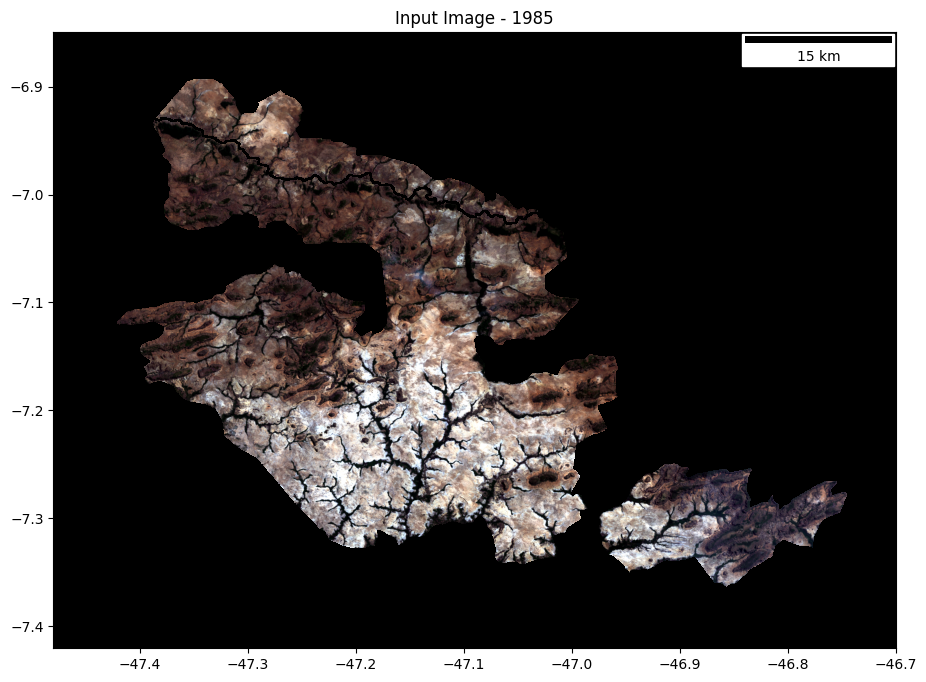

In [ ]:
# Vizualizando input arquivo raster
fig, (ax1) = plt.subplots(1, figsize=(16, 8), sharey=True)

rsgislib.tools.mapping.create_raster_img_map(
    ax1,
    input_img,
    img_bands=[9, 8, 7],
    img_stch=rsgislib.IMG_STRECTH_CUMULATIVE)
ax1.title.set_text("Input Image - 1985")

Image Data Size: 2895 x 2117
Image Data Size: 2895 x 2117


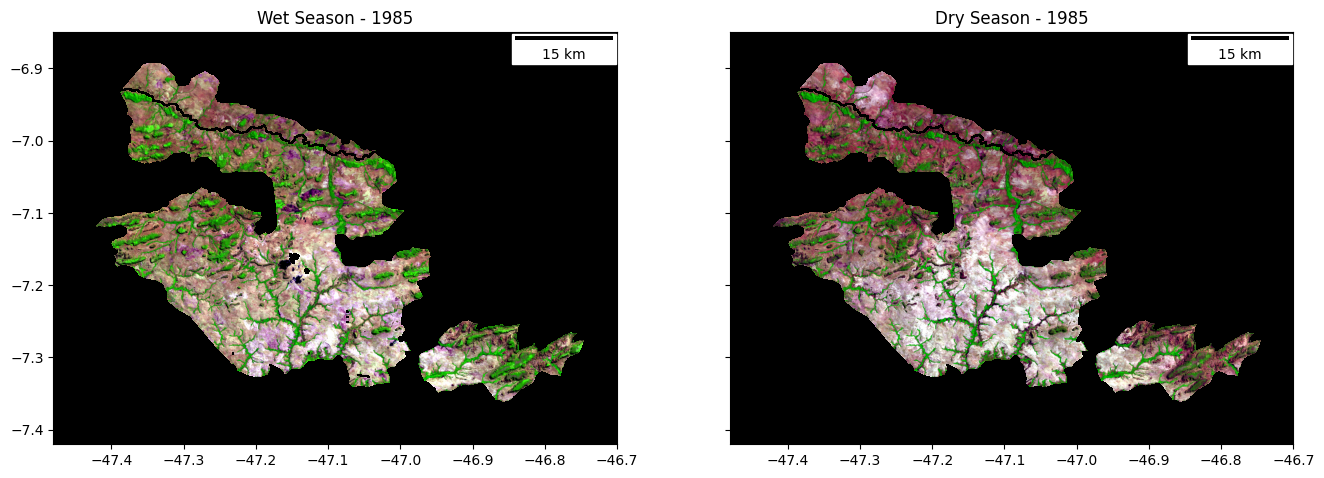

In [ ]:
# Create the matplotlib figure
# falsa cor: [5,4,3] e [11,10,9]
# cor verdadeira: [3,2,1] e [9,8,7]
# Defina a cor de fundo (white neste exemplo)
#bg_colour = [255, 255, 255]
#img_no_data_val= 0.0 #para determinar o valor de no data

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

rsgislib.tools.mapping.create_raster_img_map(
    ax1,
    input_img,
    img_bands=[5, 4, 3],
    img_stch=rsgislib.IMG_STRECTH_CUMULATIVE)
ax1.title.set_text("Wet Season - 1985")

# Add the segmentation output to the second axis.
rsgislib.tools.mapping.create_raster_img_map(
    ax2,
    input_img,
    img_bands=[11, 10, 9],
    img_stch=rsgislib.IMG_STRECTH_CUMULATIVE)
ax2.title.set_text("Dry Season - 1985")

#### Visualizando histograma das bandas

In [17]:
# Conferindo dado raster
with rio.open(input_img) as src:
    img = src.read()
img = img.transpose([1,2,0])
img.shape

(2117, 2895, 15)

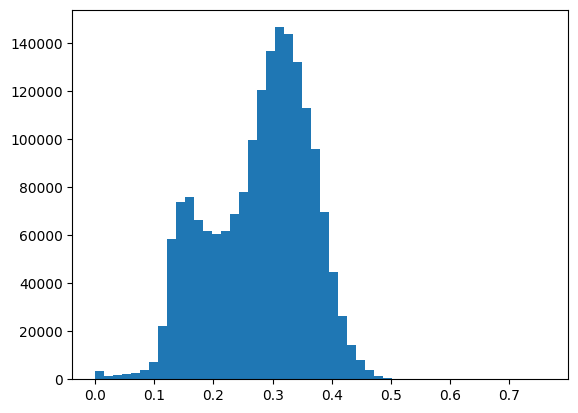

In [18]:
# Observando distribuição de histogramas
#plt.hist(img[:,:,4].flatten(), bins=100)
plt.hist(img[:,:,4].flatten(), bins=50)
#plt.hist(img[:,:,4].flatten(), bins=20)
#plt.hist(img[:,:,4].flatten(), bins=255)
plt.show()

In [19]:
img.shape[2]

15

In [20]:
# Criando função para plotar histogramas

def histogramas(cuboimg, titles=None):
  fig, axes = plt.subplots(5,3, figsize=(12,8))
  axes = axes.ravel()

  for i in range(img.shape[2]):
    axes[i].hist(cuboimg[:,:,i].flatten(), bins=30)

    if titles:
      axes[i].set_title(titles[i])  # adicionando títulos

  plt.tight_layout()
  plt.show()

# Exemplo de títulos para os histogramas
hist_titles = ["B1 - Wet Season", "B2 - Wet Season", "B3 - Wet Season",
               "B4 - Wet Season", "B5 - Wet Season", "B6 - Wet Season",
               "B1 - Dry Season", "B2 - Dry Season", "B3 - Dry Season",
               "B4 - Dry Season", "B5 - Dry Season", "B6 - Dry Season",
               "NDVI - Wet Season", "NDVI - Dry Season", "DSM"]


In [21]:
# Criando função para plotar histogramas
def histogramas(cuboimg, titles=None):
    fig, axes = plt.subplots(5, 3, figsize=(12, 8))
    axes = axes.ravel()

    for i in range(cuboimg.shape[2]):
        data = cuboimg[:, :, i].flatten()

        # Remova valores NaN e Inf
        data = data[~np.isnan(data)]
        data = data[~np.isinf(data)]

          # Remova valores zero
        data = data[data != 0]

        axes[i].hist(data, bins=100)
        if titles:
            axes[i].set_title(titles[i])  # adicionando títulos

        # Padronize o eixo x para todos os histogramas
        axes[i].set_xlim(np.min(data), np.max(data))

    plt.tight_layout()
    plt.show()

# Exemplo de títulos para os histogramas
hist_titles = ["B1 - Wet Season", "B2 - Wet Season", "B3 - Wet Season",
               "B4 - Wet Season", "B5 - Wet Season", "B6 - Wet Season",
               "B1 - Dry Season", "B2 - Dry Season", "B3 - Dry Season",
               "B4 - Dry Season", "B5 - Dry Season", "B6 - Dry Season",
               "NDVI - Wet Season", "NDVI - Dry Season", "DSM"]

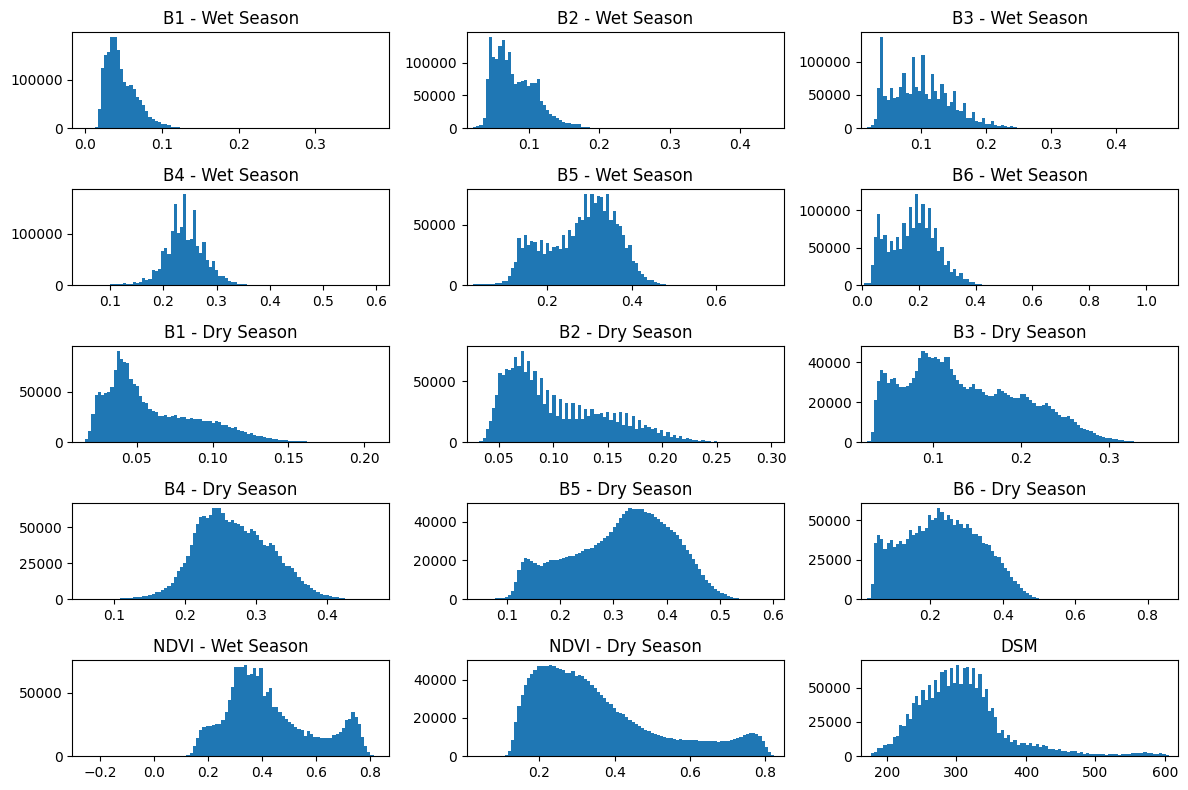

In [25]:
histogramas(img, titles=hist_titles)

#### Rodando segmentador Shepherdseg

In [ ]:
#Segmentação
#input_img

out_clumps_img = "/content/drive/MyDrive/00_vegetation_data/data/raster/1985/result_segs/seg_1985_90-400.kea" #renomear aqui a segmentação
out_mean_img = "/content/drive/MyDrive/00_vegetation_data/data/raster/1985/result_segs/meanseg_1985_90-400.kea" #renomear aqui a mascara de saida

tmp_dir = "tmp"

shepherdseg.run_shepherd_segmentation(
        input_img, #Tif de entrada
        out_clumps_img, #segmentação
        out_mean_img, #mascara da segmentação
        tmp_dir,
        gdalformat="KEA",  # Output file format
        calc_stats=True,  # Calculate statistics on the output images
        no_stretch=False,  # Normalise the input bands by applying a 2 standard devation stretch
        no_delete=False,  # Delete the temporary files created during the processing
        num_clusters=90,  # The number of clusters (k) for the initial kMeans clustering
        min_n_pxls=400,  # Minimum number of pixels within a clump (segment)
        dist_thres=10000000,  #specifies the distance threshold for joining the segments (default = 100, set to large number to turn off this option).
        #bands=None,  # is an array providing a subset of image bands to use (default is None to use all bands)
        bands=[1,2,3,4,5,6,7,8,9,10,11,12], # Just use bands 8 (NIR), 9 (SWIR) and 3 (Red) or other specifics bands
        sampling=100,  # Speed up the kMeans clustering by only using every 100th pixel.
        km_max_iter=200,  # Maximum number of kMeans iterations
        process_in_mem=True,  # Do the process using in-memory datasets rather than to disk
        save_process_stats=False,
        img_stretch_stats="",
        kmeans_centres="",
        img_stats_json_file="",
)


Subsetting the image bands
Stretch Input Image
Add 1 to stretched file to ensure there are no all zeros (i.e., no data) regions created.
Create Input Image Mask.
Mask stretched Image.
Deleting file: tmp/stack_pncm_1985_clip_stchdonly.kea
Deleting file: tmp/stack_pncm_1985_clip_stchdonly_off.kea
Deleting file: tmp/stack_pncm_1985_clip_stchdmaskonly.kea
Performing KMeans.
Apply KMeans to image.
Eliminate Single Pixels.
Perform clump.
Eliminate small pixels.
Relabel clumps.
Calculate image statistics and build pyramids.
Deleting file: tmp/stack_pncm_1985_clip_kmeansclusters.gmtxt
Deleting file: tmp/stack_pncm_1985_clip_kmeans.kea
Deleting file: tmp/stack_pncm_1985_clip_kmeans.kea.aux.xml
Deleting file: tmp/stack_pncm_1985_clip_kmeans_nosgl.kea
Deleting file: tmp/stack_pncm_1985_clip_clumps.kea
Deleting file: tmp/stack_pncm_1985_clip_clumps_elim.kea
Deleting file: tmp/stack_pncm_1985_clip_bselect.kea
Deleting file: tmp/stack_pncm_1985_clip_stchd.kea


####Transfomando arquivo ".KEA" para ".GTIFF"

In [ ]:
#Converter KEA para TIFF
!gdal_translate -of GTIFF "/content/drive/MyDrive/00_vegetation_data/data/raster/1985/result_segs/seg_1985_90-400.kea" "/content/drive/MyDrive/00_vegetation_data/data/raster/1985/result_segs/seg_1985_90-400.tif"

Input file size is 2895, 2117
ERROR 1: /content/drive/MyDrive/00_vegetation_data/data/raster/1985/result_segs/seg_1985_90-400.tif: Unable to export color table to GeoTIFF file.  Color tables can only be written to 1 band or 2 bands Byte or UInt16 GeoTIFF files.
ERROR 1: PROJ: proj_create_from_name: Open of /usr/local/share/proj failed
0...10...20...30...40...50...60...70...80...90...100 - done.


####Transfomando arquivo ".GTIFF" para ".KEA"

In [ ]:
!gdalwarp -of KEA  "/content/drive/MyDrive/00_vegetation_data/data/raster/1995/result_segs/seg_1995_90-400.tif" "/content/drive/MyDrive/00_vegetation_data/data/raster/1995/result_segs/seg_1995_90-400.kea"

Copying raster attribute table from /content/drive/MyDrive/00_vegetation_data/data/raster/1995/result_segs/seg_1995_90-400.tif to new file.
Copying color table from /content/drive/MyDrive/00_vegetation_data/data/raster/1995/result_segs/seg_1995_90-400.tif to new file.
Creating output file that is 2895P x 2117L.
Processing /content/drive/MyDrive/00_vegetation_data/data/raster/1995/result_segs/seg_1995_90-400.tif [1/1] : 0Using internal nodata values (e.g. 0) for image /content/drive/MyDrive/00_vegetation_data/data/raster/1995/result_segs/seg_1995_90-400.tif.
Copying nodata values from source /content/drive/MyDrive/00_vegetation_data/data/raster/1995/result_segs/seg_1995_90-400.tif to destination /content/drive/MyDrive/00_vegetation_data/data/raster/1995/result_segs/seg_1995_90-400.kea.
...10...20...30...40...50...60...70...80...90...100 - done.


In [ ]:
#Converter H5 para TIFF
#!gdal_translate -of GTIFF '/content/cls_smpls/ce_aberto_smpls_clumps_valid'.h5 -sds 'ce_aberto_valid_v2'.tif

Input file size is 15, 233
0...10...20...30...40...50...60...70...80...90...100 - done.


#### Reprojetando arquivo (quando necessário)

In [ ]:
data_img = rio.open('/content/drive/MyDrive/00_vegetation_data/data/raster/2022/result_segs/seg_2022_90-400.tif')
data_img.meta

{'driver': 'GTiff',
 'dtype': 'uint32',
 'nodata': 0.0,
 'width': 2895,
 'height': 2117,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.00026949458523585647, 0.0, -47.48009501602367,
        0.0, -0.00026949458523585647, -6.849743872939764)}

In [ ]:
# Abrir o arquivo de origem
with rio.open('/content/drive/MyDrive/Landsat_composite/seg_1985_90-400.tif') as src:
    # Definir as informações da projeção de destino
    dst_crs = 'EPSG:32723'
    dst_crs = 'EPSG:4326'

    # Calcular a transformação necessária
    transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)

    # Configurar as opções de saída
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    # Abrir o arquivo de destino para escrita
    with rio.open('/content/seg_1985_90-400_utm.tif', 'w', **kwargs) as dst:
        # Reprojetar o arquivo de origem para o arquivo de destino
        reproject(
            source = rio.band(src, 1),
            destination = rio.band(dst, 1),
            src_transform = src.transform,
            src_crs = src.crs,
            dst_transform = transform,
            dst_crs = dst_crs,
            resampling = Resampling.nearest
        )



#### Visualizando a Segmentação

In [27]:
# Quando os produtos já estão gravados em disco
out_clumps_img = "/content/drive/MyDrive/Vegetation_PNCM/pncm_1985_90-500-segs.kea" #selecionar aqui a segmentação
out_mean_img = "/content/drive/MyDrive/Vegetation_PNCM/pncm_1985_90-500-meanimg.kea" #selecionar aqui a mascara de saida
#tmp_dir = "tmp"

NameError: name 'rsgislib' is not defined

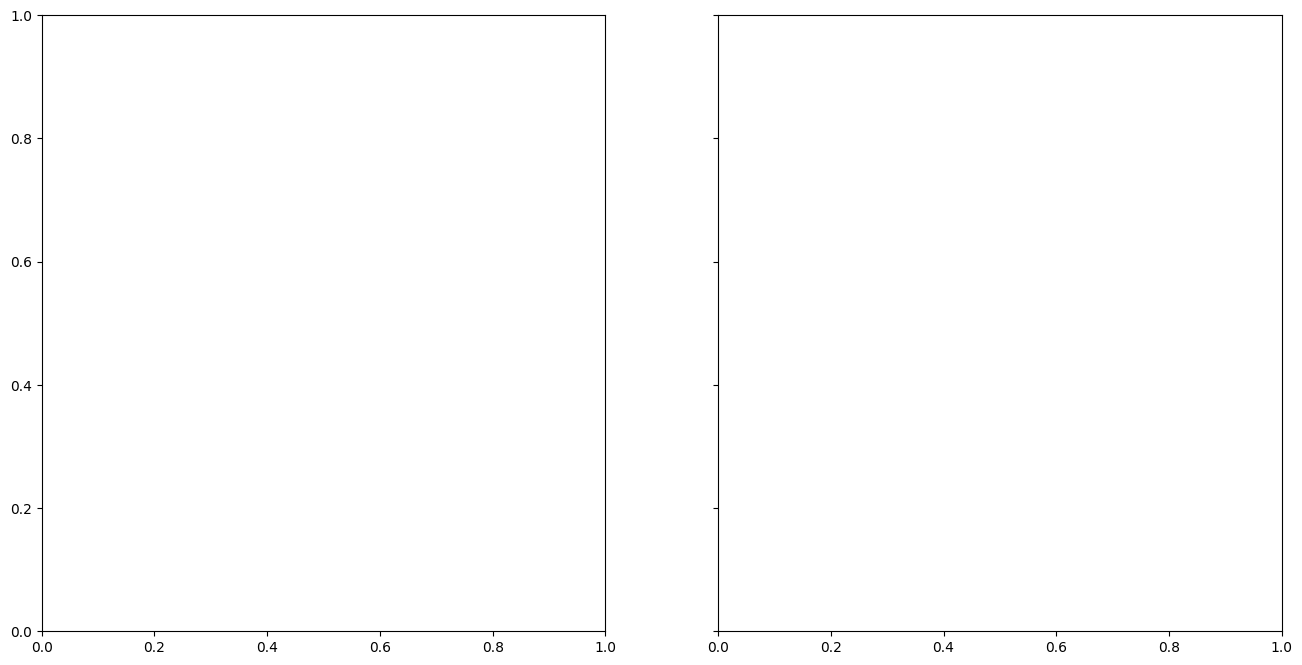

In [28]:
# Criando figura
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

rsgislib.tools.mapping.create_raster_img_map(
    ax1,
    input_img,
    img_bands=[9, 8, 7],
    img_stch=rsgislib.IMG_STRECTH_CUMULATIVE)
ax1.title.set_text("Input Image - 1985")

# Adicionando o resultado da segmentação Add the segmentation output to the second axis.
rsgislib.tools.mapping.create_thematic_raster_map(ax2, out_clumps_img)
ax2.title.set_text("Segmentation Output - 1985")

Image Data Size: 2895 x 2117
Image Data Size: 2895 x 2117


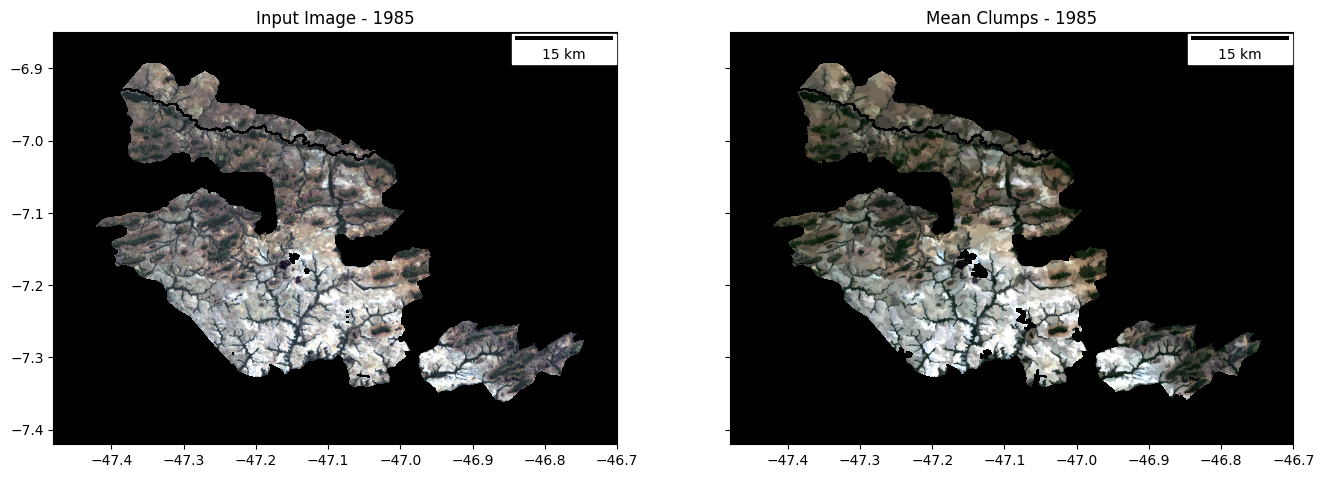

In [ ]:
# Create the matplotlib figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Specify the bands to be used for the visualisation.
band_comb = [3, 2, 1]

rsgislib.tools.mapping.create_raster_img_map(
    ax1,
    input_img,
    img_bands=band_comb,
    img_stch=rsgislib.IMG_STRETCH_STDEV)
ax1.title.set_text("Input Image - 1985")

# Add the mean segments to the second axis.
rsgislib.tools.mapping.create_raster_img_map(
    ax2,
    out_mean_img,
    img_bands=band_comb,
    img_stch=rsgislib.IMG_STRETCH_STDEV)
ax2.title.set_text("Mean Clumps - 1985")

###2.3 Classificação

#### Normalise image

In [ ]:
# The input image
input_img

'/content/drive/MyDrive/00_vegetation_data/data/raster/1985/stack_pncm_1985_clip.tif'

In [ ]:
# The output directory.
out_dir = "norm_images"

# if the output directory does not exist
# then create it.
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

In [ ]:
# Define environmental variable so outputted GeoTIFFs are tiled and compressed.
#rsgislib.imageutils.set_env_vars_lzw_gtiff_outs()

#####Linear Min--Max Normalisation

In [ ]:
#Apply Linear Min--Max Normalisation
# The output image file for the linear normalisation

#output_lin_img = os.path.join(
#    out_dir, "stack_pncm_2022_clip_norm_linear.tif"
#)

output_lin_img = '/content/drive/MyDrive/00_vegetation_data/data/raster/1995/stack_pncm_1995_clip_norm_linear.tif'

# Run the linear normalisation where all the input image
# band will independently be normalised so the minimum
# value is 1 and the maximum value is 1000.
rsgislib.imageutils.normalise_img_pxl_vals(
    input_img=input_img,
    output_img=output_lin_img,
    gdalformat="GTIFF",
    datatype=rsgislib.TYPE_16UINT,
    in_no_data_val=0.0,
    out_no_data_val=0.0,
    out_min=1,
    out_max=1000,
    stretch_type=STRETCH_LINEARMINMAX,
)

# Calculate image statistics and pyramids for the output image
rsgislib.imageutils.pop_img_stats(
    output_lin_img, use_no_data=True, no_data_val=0.0, calc_pyramids=True
)

##### Linear Standard Deviation Normalisation

In [ ]:
#Apply Linear Standard Deviation Normalisation
# The output image file for the standard deviation normalisation
output_sd_img = os.path.join(
    out_dir, "stack_pncm_1985_clip_norm_stddev.tif"
)

# Run the standard deviation normalisation
rsgislib.imageutils.normalise_img_pxl_vals(
    input_img,
    output_sd_img,
    "GTIFF",
    rsgislib.TYPE_16UINT,
    in_no_data_val=0,
    out_no_data_val=0,
    out_min=0,
    out_max=1000,
    stretch_type=STRETCH_LINEARSTDDEV,
    stretch_param=2,
)

# Calculate image statistics and pyramids for the output image
rsgislib.imageutils.pop_img_stats(
    output_sd_img, use_no_data=True, no_data_val=0, calc_pyramids=True
)

#### Carregando imagem para classificação.

In [ ]:
output_lin_img = '/content/drive/MyDrive/00_vegetation_data/data/raster/1985/stack_pncm_1985_clip_norm_linear.tif'
output_lin_img

'/content/drive/MyDrive/00_vegetation_data/data/raster/1985/stack_pncm_1985_clip_norm_linear.tif'

In [ ]:
# Carregando imagem para classificação.
#Define Input Image bands
input_img = output_lin_img
#input_img=output_sd_img
#input_img

img_band_info = list()
img_band_info.append(
    rsgislib.imageutils.ImageBandInfo(
        file_name=input_img, name="pncm", bands=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,14,15]
    )
)


#### Vetorização do Segmentos

In [ ]:
#out_mean_img
#clumps_img = out_clumps_img
clumps_img = '/content/drive/MyDrive/00_vegetation_data/data/raster/1985/result_segs/seg_1985_90-400.kea'
#clumps_img2 = '/content/classific_results/pncm_1985_classificadav2.kea'
clumps_img

'/content/drive/MyDrive/00_vegetation_data/data/raster/1985/result_segs/seg_1985_90-400.kea'

In [ ]:
segs_vec_file = "/content/drive/MyDrive/00_vegetation_data/data/shp/1985/amostra_class/seg_1985_90-400.gpkg"
segs_vec_lyr = "seg_1985_90-400"

#segs_vec_file = "/content/seg_2020_90-400.gpkg"
#segs_vec_lyr = "seg_2020_90-400"

rsgislib.vectorutils.createvectors.polygonise_raster_to_vec_lyr(
    out_vec_file=segs_vec_file,  # The output vector file name and path
    out_vec_lyr=segs_vec_lyr,  # The output vector layer name
    out_format="GPKG",  # The output vector format
    input_img=clumps_img,  # The input segmentation image
    img_band=1,  # The band within the input image
    mask_img=clumps_img,  # A mask image (usually the same as the input image)
    mask_band=1,  # The band within the mask image
)

  8%|▊         | 8/100 [00:00<00:01, 70.01it/s]

Polygonising...


101it [00:32,  3.13it/s]                        

Completed


#### Extraindo seguimentos com base nas amostras de classificação.



In [ ]:
# ce_aberto
# ce_denso
# ce_rupestre
# ced_altitude
# ced_planicie
# mat_galeria
# mosaic_agri_past
#nomes = list('ce_aberto', 'ce_denso')

In [ ]:
# Criação de função para gerar ROIs a partir de amostras e com base nos seguimentos

def roi_create(pol_file, pts_file):
  pol = gpd.read_file(pol_file)
  pts = gpd.read_file(pts_file)
  join_right_df = pts.sjoin(pol, how='right')
  res = join_right_df.query("id >= 1") #inseri nome da coluna que tem os valores das classes
  res.to_file('/content/drive/MyDrive/00_vegetation_data/data/shp/1985/amostra_class/amostras_seg/ce_aberto.shp') #nomear arquivo criado
  print('ROI criada!')
  return res


In [ ]:
#Extraindo amostras de seguimentos
segmentos = segs_vec_file
pts_amost = '/content/drive/MyDrive/00_vegetation_data/data/shp/1985/amostra_class/ce_aberto.shp'
roi_create(segmentos, pts_amost)

ROI criada!


/usr/local/lib/python3.10/site-packages/geopandas/geodataframe.py:2189: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: GEOGCS["Undefined geographic SRS",DATUM["unknown", ...

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)  # noqa: B026


index_left   id class_name  PXLVAL  \
6            8.0  1.0  ce_aberto      12   
7            0.0  1.0  ce_aberto       6   
24          35.0  1.0  ce_aberto      21   
39          36.0  1.0  ce_aberto      36   
81          26.0  1.0  ce_aberto      56   
130         25.0  1.0  ce_aberto     118   
172         21.0  1.0  ce_aberto     180   
404         19.0  1.0  ce_aberto     383   
417          1.0  1.0  ce_aberto     302   
540          9.0  1.0  ce_aberto     525   
552         37.0  1.0  ce_aberto     577   
589          7.0  1.0  ce_aberto     597   
689          6.0  1.0  ce_aberto     693   
818          3.0  1.0  ce_aberto     799   
995         10.0  1.0  ce_aberto    1002   
1012        20.0  1.0  ce_aberto    1016   
1027         4.0  1.0  ce_aberto    1048   
1158         5.0  1.0  ce_aberto    1188   
1172        27.0  1.0  ce_aberto    1178   
1331         2.0  1.0  ce_aberto    1204   
1424        18.0  1.0  ce_aberto    1421   
1438        11.0  1.0  ce_aberto    1451   
1484        29.0  1.0  ce_aberto    1509   
1490        16.0  1.0  ce_aberto    1456   
1527        30.0  1.0  ce_aberto    1516   
1646        31.0  1.0  ce_aberto    1619   
1686        23.0  1.0  ce_aberto    1639   
1708        14.0  1.0  ce_aberto    1719   
1717        24.0  1.0  ce_aberto    1711   
1722        22.0  1.0  ce_aberto    1726   
1840        15.0  1.0  ce_aberto    1826   
1943        28.0  1.0  ce_aberto    1820   
1964        32.0  1.0  ce_aberto    1993   
2035        12.0  1.0  ce_aberto    2070   
2055        13.0  1.0  ce_aberto    2061   
2056        33.0  1.0  ce_aberto    2000   
2132        34.0  1.0  ce_aberto    2128   
2266        17.0  1.0  ce_aberto    2276   

                                               geometry  
6     POLYGON ((-47.36044 -6.89906, -47.36017 -6.899...  
7     POLYGON ((-47.33295 -6.89448, -47.33241 -6.894...  
24    POLYGON ((-47.35855 -6.90553, -47.35747 -6.905...  
39    POLYGON ((-47.27070 -6.91415, -47.27016 -6.914...  
81    POLYGON ((-47.28121 -6.92305, -47.28040 -6.923...  
130   POLYGON ((-47.28390 -6.95134, -47.28336 -6.951...  
172   POLYGON ((-47.33133 -6.96886, -47.33106 -6.968...  
404   POLYGON ((-47.19254 -7.00659, -47.19227 -7.006...  
417   POLYGON ((-47.24968 -6.99177, -47.24914 -6.991...  
540   POLYGON ((-47.12598 -7.03462, -47.12544 -7.034...  
552   POLYGON ((-47.07235 -7.04782, -47.07181 -7.047...  
589   POLYGON ((-47.12490 -7.05699, -47.12463 -7.056...  
689   POLYGON ((-47.15455 -7.08178, -47.15428 -7.081...  
818   POLYGON ((-47.28525 -7.10064, -47.28471 -7.100...  
995   POLYGON ((-47.32325 -7.13137, -47.32244 -7.131...  
1012  POLYGON ((-47.27824 -7.13379, -47.27770 -7.133...  
1027  POLYGON ((-47.10550 -7.13864, -47.10523 -7.138...  
1158  POLYGON ((-47.10307 -7.16101, -47.10199 -7.161...  
1172  POLYGON ((-47.19524 -7.15939, -47.19497 -7.159...  
1331  POLYGON ((-46.98449 -7.16317, -46.98396 -7.163...  
1424  POLYGON ((-47.10172 -7.19497, -47.10146 -7.194...  
1438  POLYGON ((-47.27366 -7.19955, -47.27124 -7.199...  
1484  POLYGON ((-47.08798 -7.20844, -47.08798 -7.208...  
1490  POLYGON ((-47.06400 -7.20009, -47.06130 -7.200...  
1527  POLYGON ((-47.29657 -7.20952, -47.29549 -7.209...  
1646  POLYGON ((-47.26666 -7.22488, -47.26639 -7.224...  
1686  POLYGON ((-47.11008 -7.22838, -47.10846 -7.228...  
1708  POLYGON ((-47.03489 -7.24374, -47.03462 -7.243...  
1717  POLYGON ((-47.26531 -7.24240, -47.26450 -7.242...  
1722  POLYGON ((-47.12598 -7.24509, -47.12544 -7.245...  
1840  POLYGON ((-47.21680 -7.26018, -47.21626 -7.260...  
1943  POLYGON ((-47.09364 -7.25884, -47.09310 -7.258...  
1964  POLYGON ((-47.00686 -7.28094, -47.00632 -7.280...  
2035  POLYGON ((-47.18419 -7.29010, -47.18096 -7.290...  
2055  POLYGON ((-47.21680 -7.28875, -47.21491 -7.288...  
2056  POLYGON ((-47.02977 -7.28228, -47.02950 -7.282...  
2132  POLYGON ((-46.87858 -7.29764, -46.87804 -7.297...  
2266  POLYGON ((-46.92224 -7.32298, -46.92143 -7.322...

##### Visualise Segmentation Vector

In [ ]:
#BBOX
bbox_test = rsgislib.imageutils.get_img_bbox("/content/seg_1985_90-500.kea")
bbox_test

[-47.48009501602367,
 -46.699908191765864,
 -7.420263909884072,
 -6.849743872939764]

Image Data Size: 1113 x 1114
Image Data Size: 1113 x 1114


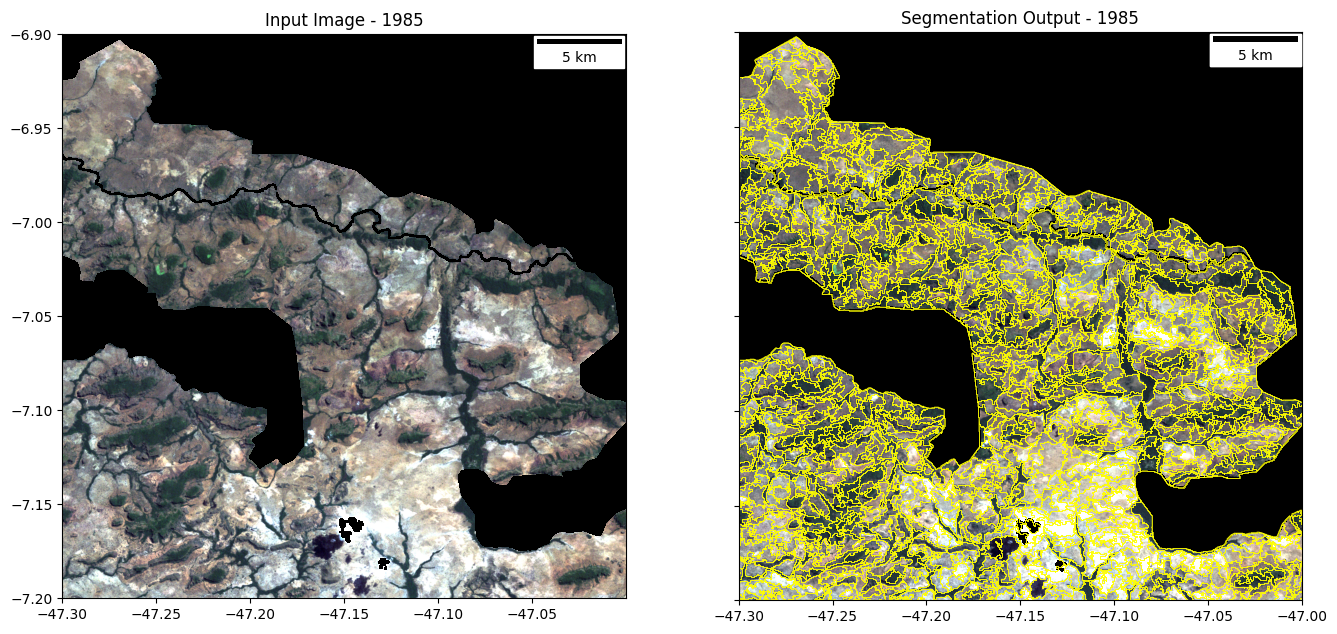

In [ ]:
# Define a bbox for the subset to be displayed

#sub_img_bbox = [-47.5, -46.7, -7.4, -6.9] #xmin, xmax, ymin, ymax
sub_img_bbox = [-47.3, -47.0, -7.2, -6.9]


# Subset bbox reformated for geopandas
gp_img_bbox = [sub_img_bbox[0], sub_img_bbox[2], sub_img_bbox[1], sub_img_bbox[3]]

# Use geopandas to read the vector layer
segs_gdf = gpd.read_file(segs_vec_file, layer=segs_vec_lyr, bbox=gp_img_bbox)
segs_gdf.crs = "EPSG:4326"

# Create the matplotlib figure - in this case two plots so the NDVI
# and image are plotted alongside each other
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

rsgislib.tools.mapping.create_raster_img_map(
    ax1,
    input_img,
    img_bands=[3, 2, 1],
    img_stch=rsgislib.IMG_STRETCH_STDEV,
    bbox=sub_img_bbox,
    title_str="Input Image - 1985",
    show_scale_bar=True,
)

rsgislib.tools.mapping.create_raster_img_map(
    ax2,
    input_img,
    img_bands=[3, 2, 1],
    img_stch=rsgislib.IMG_STRETCH_STDEV,
    bbox=sub_img_bbox,
    show_scale_bar=True,
)

# Plot the polygons boundaries an edge colour of yellow.
# i.e., just the polygon outlines in yellow.
rsgislib.tools.mapping.create_vec_lyr_map(
        ax2,
        segs_gdf.boundary,
        bbox=sub_img_bbox,
        title_str="Segmentation Output - 1985",
        vec_fill_clrs="yellow",
        vec_line_widths=0.5
        )

#### Populate Clumps

##### Populate Image Reflectance Data

In [ ]:
# Populate with all statistics (min, max, mean, standard deviation)
bs = []
bs.append(rsgislib.rastergis.BandAttStats(band=1, min_field='b1Min', max_field='b1Max',mean_field="b1Mean",
                                          sum_field='b1Sum', std_dev_field='b1StdDev'))
bs.append(rsgislib.rastergis.BandAttStats(band=2, min_field='b2Min', max_field='b2Max',mean_field="b2Mean",
                                          sum_field='b2Sum', std_dev_field='b2StdDev'))
bs.append(rsgislib.rastergis.BandAttStats(band=3,min_field='b3Min', max_field='b3Max', mean_field='b3Mean',
                                          sum_field='b3Sum', std_dev_field='b3StdDev'))
bs.append(rsgislib.rastergis.BandAttStats(band=4, min_field='b4Min', max_field='b4Max', mean_field='b4Mean',
                                          sum_field='b4Sum', std_dev_field='b4StdDev'))
bs.append(rsgislib.rastergis.BandAttStats(band=5, min_field='b5Min', max_field='b5Max', mean_field='b5Mean',
                                          sum_field='b5Sum', std_dev_field='b5StdDev'))
bs.append(rsgislib.rastergis.BandAttStats(band=6, min_field='b6Min', max_field='b6Max', mean_field='b6Mean',
                                          sum_field='b6Sum', std_dev_field='b6StdDev'))
bs.append(rsgislib.rastergis.BandAttStats(band=7, min_field='b7Min', max_field='b7Max', mean_field='b7Mean',
                                          sum_field='b7Sum', std_dev_field='b7StdDev'))
bs.append(rsgislib.rastergis.BandAttStats(band=8, min_field='b8Min', max_field='b8Max', mean_field='b8Mean',
                                          sum_field='b8Sum', std_dev_field='b8StdDev'))
bs.append(rsgislib.rastergis.BandAttStats(band=9, min_field='b9Min', max_field='b9Max', mean_field='b9Mean',
                                          sum_field='b9Sum', std_dev_field='b9StdDev'))
bs.append(rsgislib.rastergis.BandAttStats(band=10, min_field='b10Min', max_field='b10Max', mean_field='b10Mean',
                                          sum_field='b10Sum', std_dev_field='b10StdDev'))
bs.append(rsgislib.rastergis.BandAttStats(band=11, min_field='b11Min', max_field='b11Max', mean_field='b11Mean',
                                          sum_field='b11Sum', std_dev_field='b11StdDev'))
bs.append(rsgislib.rastergis.BandAttStats(band=12, min_field='b12Min', max_field='b12Max', mean_field='b12Mean',
                                          sum_field='b12Sum', std_dev_field='b12StdDev'))
bs.append(rsgislib.rastergis.BandAttStats(band=13, min_field='b13Min', max_field='b13Max', mean_field='b13Mean',
                                          sum_field='b13Sum', std_dev_field='b13StdDev'))
bs.append(rsgislib.rastergis.BandAttStats(band=14, min_field='b14Min', max_field='b14Max', mean_field='b14Mean',
                                          sum_field='b14Sum', std_dev_field='b14StdDev'))
bs.append(rsgislib.rastergis.BandAttStats(band=15, min_field='b15Min', max_field='b15Max', mean_field='b15Mean',
                                          sum_field='b15Sum', std_dev_field='b15StdDev'))

rsgislib.rastergis.populate_rat_with_stats(input_img, clumps_img, bs)



In [ ]:
clumps_img

'/content/drive/MyDrive/00_vegetation_data/data/raster/1985/result_segs/seg_1985_90-400.kea'

#### Populate Training Data

In [ ]:
# o dado de entrada deve ser um gpkg
#vec_train_file = "/content/drive/MyDrive/00_vegetation_data/data/shp/1985/amostras_1985.gpkg"
#vec_train_file = "/content/drive/MyDrive/00_vegetation_data/data/shp/1985/amostras_pontos_del_validPonts/amostras_1985.gpkg"

#vec_train_file

'/content/drive/MyDrive/00_vegetation_data/data/shp/1985/amostras_pontos_del_validPonts/amostras_1985.gpkg'

In [ ]:
# Create Training Rasterise tmp directory
tmp_train_dir = "train_tmp"
if not os.path.exists(tmp_train_dir):
    os.mkdir(tmp_train_dir)

#vec_train_file = "/content/drive/MyDrive/00_vegetation_data/data/shp/2022/amostra_class/amostras_seg/amostras_segs_2022.gpkg"
#vec_train_file = '/content/drive/MyDrive/00_vegetation_data/data/shp/1985/amostras_seg/amostras_segs_1985_new.gpkg'
vec_train_file = '/content/drive/MyDrive/00_vegetation_data/data/shp/1985/amostra_class/amostras_seg/amostras_segs_1985.gpkg'

# Define Training Data
class_vec_sample_clumps_info = list()

# Define the file name of the samples HDF5 file, which will be created
ce_aberto_clumps_h5 = "ce_aberto_smpls_clumps.h5"
class_vec_sample_clumps_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=1,
        class_name="ce_aberto",
        vec_file=vec_train_file,
        vec_lyr="ce_aberto",
        file_h5=ce_aberto_clumps_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
ce_denso_clumps_h5 = "ce_denso_smpls_clumps.h5"
class_vec_sample_clumps_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=2,
        class_name="ce_denso",
        vec_file=vec_train_file,
        vec_lyr="ce_denso",
        file_h5=ce_denso_clumps_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
ce_rupestre_clumps_h5 = "ce_rupestre_smpls_clumps.h5"
class_vec_sample_clumps_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=3,
        class_name="ce_rupestre",
        vec_file=vec_train_file,
        vec_lyr="ce_rupestre",
        file_h5=ce_rupestre_clumps_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
ced_altitude_clumps_h5 = "ced_altitude_smpls_clumps.h5"
class_vec_sample_clumps_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=4,
        class_name="ced_altitude",
        vec_file=vec_train_file,
        vec_lyr="ced_altitude",
        file_h5=ced_altitude_clumps_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
ced_planicie_clumps_h5 = "ced_planicie_smpls_clumps.h5"
class_vec_sample_clumps_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=5,
        class_name="ced_planicie",
        vec_file=vec_train_file,
        vec_lyr="ced_planicie",
        file_h5=ced_planicie_clumps_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
mat_galeria_clumps_h5 = "mat_galeria_smpls_clumps.h5"
class_vec_sample_clumps_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=6,
        class_name="mat_galeria",
        vec_file=vec_train_file,
        vec_lyr="mat_galeria",
        file_h5=mat_galeria_clumps_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
mosaic_agri_past_clumps_h5 = "mosaic_agri_past_smpls_clumps.h5"
class_vec_sample_clumps_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=7,
        class_name="mosaic_agri_past",
        vec_file=vec_train_file,
        vec_lyr="mosaic_agri_past",
        file_h5=mosaic_agri_past_clumps_h5,
    )
)

rsgislib.classification.classratutils.populate_clumps_with_class_training(
    clumps_img,
    class_vec_sample_clumps_info,
    tmp_train_dir,
    classes_int_col="class_int_smpls",
    classes_name_col="class_name_smpls",
)


Creating output image using input image
Running Rasterise now...
Creating output image using input image
Running Rasterise now...
Creating output image using input image
Running Rasterise now...
Creating output image using input image
Running Rasterise now...
Creating output image using input image
Running Rasterise now...
Creating output image using input image
Running Rasterise now...
Creating output image using input image
Running Rasterise now...
Deleting file: train_tmp/ce_aberto_a58f340142.kea
Deleting file: train_tmp/ce_denso_a58f340142.kea
Deleting file: train_tmp/ce_rupestre_a58f340142.kea
Deleting file: train_tmp/ced_altitude_a58f340142.kea
Deleting file: train_tmp/ced_planicie_a58f340142.kea
Deleting file: train_tmp/mat_galeria_a58f340142.kea
Deleting file: train_tmp/mosaic_agri_past_a58f340142.kea
Deleting file: train_tmp/CombinedClasses_a58f340142.kea


In [ ]:
# Get the list of layers within the vector file.
lyr_names = rsgislib.vectorutils.get_vec_lyrs_lst(vec_train_file)

# Print out the layer names by looping through the list of layers returned.
# Note. the enumerate function returns the array index and the list value:
for i, lyr_name in enumerate(lyr_names):
    print(f"{i+1}:\t{lyr_name}")

1:	ce_aberto
2:	ce_denso
3:	ce_rupestre
4:	ced_altitude
5:	ced_planicie
6:	mat_galeria
7:	mosaic_agri_past


#### Extract Sample Data

##### cols

In [ ]:
# Columns to be extracted and used for classification
cols = ['b1Mean','b2Mean','b3Mean','b4Mean','b5Mean','b6Mean','b7Mean','b8Mean',
        'b9Mean','b10Mean','b11Mean','b12Mean','b13Mean','b14Mean','b15Mean']

In [ ]:
cols = ['b1StdDev','b2StdDev','b3StdDev', 'b4StdDev','b5StdDev', 'b6StdDev','b7StdDev','b8StdDev',
        'b9StdDev','b10StdDev','b11StdDev','b12StdDev','b13StdDev','b14StdDev', 'b15StdDev']

#### Extract Clumps Sample Data

In [ ]:
# Reading classification column from RAT.
# Columns to be extracted and used for classification

class_int_smpls_col = rsgislib.rastergis.get_column_data(clumps_img, "class_int_smpls")

# Get the unique classes (i.e., there are samples for the class)
unq_classes = np.unique(class_int_smpls_col)

cls_smpls_clumps_info = dict()

# Loop through each of the classes to extract the samples to a HDF5
for class_vec_sample in class_vec_sample_clumps_info:
    print("{}:".format(class_vec_sample.class_name))
    # Check the class is within the list of unique classes
    if class_vec_sample.id in unq_classes:
        # Extract the class samples to a HDF5 file
        rsgislib.classification.classratutils.extract_rat_col_data(
            clumps_img,
            cols,
            "class_int_smpls",
            class_vec_sample.id,
            class_vec_sample.file_h5,
            datatype=rsgislib.TYPE_32FLOAT,
        )
        cls_smpls_clumps_info[
            class_vec_sample.class_name
        ] = rsgislib.classification.ClassSimpleInfoObj(
            id=class_vec_sample.id, file_h5=class_vec_sample.file_h5
        )

ce_aberto:
n feats: 38
n cols: 15
ce_denso:
n feats: 23
n cols: 15
ce_rupestre:
n feats: 25
n cols: 15
ced_altitude:
n feats: 39
n cols: 15
ced_planicie:
n feats: 16
n cols: 15
mat_galeria:
n feats: 64
n cols: 15
mosaic_agri_past:
n feats: 21
n cols: 15


##### OBS:
Note, the number of samples (i.e., 'n feats') is low (i.e., < 56) and
this will produce a poor quality classification as samples will need to be
split into training, testing and validation sets. The number of samples is low
because the segments clumps a number of pixels together identifying regions
which are (hopefully) the same class. Therefore, if a clump is 50 pixels then
this would produce a single classification sample compared to 50 if the samples
were extract from individual pixels.

Note-se que o número de amostras (i.e., 'n feats') é baixo (i.e., < 56) e isto produzirá uma classificação de fraca qualidade, uma vez que as amostras terão de ser divididas em conjuntos de treino, teste e validação. O número de amostras é baixo porque os segmentos agrupam um número de pixels identificando regiões que são (esperamos) da mesma classe. Assim, se um aglomerado tiver 50 pixels, produzirá uma única amostra de classificação, em comparação com 50 se as amostras forem extraídas de pixels individuais.

#### Extract Pixel Sample Data

In [ ]:
class_vec_sample_clumps_info = list()

# Define the file name of the samples HDF5 file, which will be created
ce_aberto_clumps_h5 = "ce_aberto_smpls_clumps.h5"
class_vec_sample_clumps_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=1,
        class_name="ce_aberto",
        vec_file=vec_train_file,
        vec_lyr="ce_aberto",
        file_h5=ce_aberto_clumps_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
ce_denso_clumps_h5 = "ce_denso_smpls_clumps.h5"
class_vec_sample_clumps_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=2,
        class_name="ce_denso",
        vec_file=vec_train_file,
        vec_lyr="ce_denso",
        file_h5=ce_denso_clumps_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
ce_rupestre_clumps_h5 = "ce_rupestre_smpls_clumps.h5"
class_vec_sample_clumps_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=3,
        class_name="ce_rupestre",
        vec_file=vec_train_file,
        vec_lyr="ce_rupestre",
        file_h5=ce_rupestre_clumps_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
ced_altitude_clumps_h5 = "ced_altitude_smpls_clumps.h5"
class_vec_sample_clumps_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=4,
        class_name="ced_altitude",
        vec_file=vec_train_file,
        vec_lyr="ced_altitude",
        file_h5=ced_altitude_clumps_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
ced_planicie_clumps_h5 = "ced_planicie_smpls_clumps.h5"
class_vec_sample_clumps_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=5,
        class_name="ced_planicie",
        vec_file=vec_train_file,
        vec_lyr="ced_planicie",
        file_h5=ced_planicie_clumps_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
mat_galeria_clumps_h5 = "mat_galeria_smpls_clumps.h5"
class_vec_sample_clumps_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=6,
        class_name="mat_galeria",
        vec_file=vec_train_file,
        vec_lyr="mat_galeria",
        file_h5=mat_galeria_clumps_h5,
    )
)

# Define the file name of the samples HDF5 file, which will be created
mosaic_agri_past_clumps_h5 = "mosaic_agri_past_smpls_clumps.h5"
class_vec_sample_clumps_info.append(
    rsgislib.classification.ClassVecSamplesInfoObj(
        id=7,
        class_name="mosaic_agri_past",
        vec_file=vec_train_file,
        vec_lyr="mosaic_agri_past",
        file_h5=mosaic_agri_past_clumps_h5,
    )
)

cls_smpls_pixel_info = rsgislib.classification.get_class_training_data(
    img_band_info, class_vec_sample_clumps_info, tmp_train_dir, ref_img=input_img
)

Creating output image using input image
Running Rasterise now...
Creating output image using input image
Running Rasterise now...
Creating output image using input image
Running Rasterise now...
Creating output image using input image
Running Rasterise now...
Creating output image using input image
Running Rasterise now...
Creating output image using input image
Running Rasterise now...
Creating output image using input image
Running Rasterise now...


In [ ]:
print("Number of Samples:")
cls_smpls_info = dict()
for class_name in cls_smpls_pixel_info:
    h5_files = [cls_smpls_pixel_info[class_name].file_h5]
    if class_name in cls_smpls_clumps_info:
        h5_files.append(cls_smpls_clumps_info[class_name].file_h5)

    out_file_h5 = cls_smpls_pixel_info[class_name].file_h5.replace("_pixels", "")
    rsgislib.zonalstats.merge_extracted_hdf5_data(
        h5_files, out_file_h5, datatype=rsgislib.TYPE_32FLOAT
    )
    cls_smpls_info[class_name] = rsgislib.classification.ClassSimpleInfoObj(
        id=cls_smpls_pixel_info[class_name].id,
        file_h5=out_file_h5,
        blue=cls_smpls_pixel_info[class_name].blue,
        green=cls_smpls_pixel_info[class_name].green,
        red=cls_smpls_pixel_info[class_name].red,
    )

    print(
        "\t{}: {}".format(
            class_name, rsgislib.classification.get_num_samples(out_file_h5)
        )
    )

Number of Samples:
	ce_aberto: 93246
	ce_denso: 39690
	ce_rupestre: 42496
	ced_altitude: 62628
	ced_planicie: 28322
	mat_galeria: 106734
	mosaic_agri_past: 34774


#### Definindo cores

In [ ]:
# Define Class Colours
cls_smpls_info["ce_aberto"].red = 204
cls_smpls_info["ce_aberto"].green = 255
cls_smpls_info["ce_aberto"].blue = 102

cls_smpls_info["ce_denso"].red = 102
cls_smpls_info["ce_denso"].green = 153
cls_smpls_info["ce_denso"].blue = 0

cls_smpls_info["ce_rupestre"].red = 128
cls_smpls_info["ce_rupestre"].green = 0
cls_smpls_info["ce_rupestre"].blue = 0

cls_smpls_info["ced_altitude"].red = 0
cls_smpls_info["ced_altitude"].green = 102
cls_smpls_info["ced_altitude"].blue = 0

cls_smpls_info["ced_planicie"].red = 60
cls_smpls_info["ced_planicie"].green = 179
cls_smpls_info["ced_planicie"].blue = 113

cls_smpls_info["mat_galeria"].red = 0
cls_smpls_info["mat_galeria"].green = 255
cls_smpls_info["mat_galeria"].blue = 0

cls_smpls_info["mosaic_agri_past"].red = 255
cls_smpls_info["mosaic_agri_past"].green = 165
cls_smpls_info["mosaic_agri_past"].blue = 0

#### Split Samples for Training, Testing and Validation

In [ ]:
# Define Sample Data and Class Colours
smpls_dir = "cls_smpls"
if not os.path.exists(smpls_dir):
    os.mkdir(smpls_dir)

cls_smpls_fnl_info = rsgislib.classification.get_class_info_dict(
    cls_smpls_info, smpls_dir
)

# Run the create_train_valid_test_sets helper function to
# create the train, valid and test datasets
rsgislib.classification.create_train_valid_test_sets(
    cls_smpls_info, cls_smpls_fnl_info, 250, 250, 500
)

# 250, 250, 500

#11019, 11019, 22038
#29, 29, 50
#232, 232, 466

0=1: (Train:cls_smpls/ce_aberto_smpls_clumps_train.h5, Test:cls_smpls/ce_aberto_smpls_clumps_test.h5, Valid:cls_smpls/ce_aberto_smpls_clumps_valid.h5), (204, 255, 102)
1=2: (Train:cls_smpls/ce_denso_smpls_clumps_train.h5, Test:cls_smpls/ce_denso_smpls_clumps_test.h5, Valid:cls_smpls/ce_denso_smpls_clumps_valid.h5), (102, 153, 0)
2=3: (Train:cls_smpls/ce_rupestre_smpls_clumps_train.h5, Test:cls_smpls/ce_rupestre_smpls_clumps_test.h5, Valid:cls_smpls/ce_rupestre_smpls_clumps_valid.h5), (128, 0, 0)
3=4: (Train:cls_smpls/ced_altitude_smpls_clumps_train.h5, Test:cls_smpls/ced_altitude_smpls_clumps_test.h5, Valid:cls_smpls/ced_altitude_smpls_clumps_valid.h5), (0, 102, 0)
4=5: (Train:cls_smpls/ced_planicie_smpls_clumps_train.h5, Test:cls_smpls/ced_planicie_smpls_clumps_test.h5, Valid:cls_smpls/ced_planicie_smpls_clumps_valid.h5), (60, 179, 113)
5=6: (Train:cls_smpls/mat_galeria_smpls_clumps_train.h5, Test:cls_smpls/mat_galeria_smpls_clumps_test.h5, Valid:cls_smpls/mat_galeria_smpls_clumps_val

#### Optimise Classifier Hyperparameters

In [ ]:
grid_search = GridSearchCV(
    RandomForestClassifier(),
    param_grid={
        "n_estimators": [300, 350, 400, 450, 500],
        "max_depth": [1000, 1100, 1200, 1300, 1500]
    },
)

#"max_features": [75]
#"n_estimators": [100, 150, 200, 300, 400, 1000],
#"max_depth": [20, 100, 500, 700, 1000],
#n_features = 75
#"n_estimators": [150, 200, 300, 350, 400, 450],
#"max_depth": [100, 200, 300, 1000, 1250, 1500]

sk_classifier = (
    rsgislib.classification.classsklearn.perform_sklearn_classifier_param_search(
        cls_smpls_fnl_info, grid_search
    )
)

### outra forma (maior tempo de execução)
# lista para ser aplica no grid_search
#lista1 = list(range(100, 200, 1))
#lista1
#lista2 = list(range(100, 1000, 10))
#grid_search = GridSearchCV(
#    RandomForestClassifier(),
#    param_grid={
#        "n_estimators": lista1,
#        "max_depth": lista2,
#    },
#)

Training data size: 1969 x 15
Best score was 0.6587127523540125 and has parameters {'max_depth': 1100, 'n_estimators': 450}.


#### Train Classification

In [ ]:
rsgislib.classification.classsklearn.train_sklearn_classifier(
    cls_smpls_fnl_info, sk_classifier
)

Training data size: 3674 x 15
Testing data size: 1917 x 15
Training Classifier
Completed
Calc Classifier Accuracy
Classifier Train Score = 99.97%
Classifier Test Score = 72.61%


(0.9997278170930866, 0.7261345852895149)

In [ ]:
# Aplicando o classificador sem o grid_search
#from sklearn.ensemble import RandomForestClassifier
#skclf = RandomForestClassifier(n_estimators=300, max_depth=250)

#cls_train_info = dict()
#cls_train_info['Mangroves'] = rsgislib.classification.ClassSimpleInfoObj(id=1, fileH5='mangrove_cls_samples_train.h5', red=0, green=255, blue=0)
#cls_train_info['Other'] = rsgislib.classification.ClassSimpleInfoObj(id=2, fileH5='other_cls_samples_train.h5', red=100, green=100, blue=100)

#rsgislib.classification.classsklearn.train_sklearn_classifier(cls_train_info, skclf)


#####Criando tabela com os valores do classificador

In [ ]:
# Train the classifier (criando tabela com os valores do classificador)
acc_stats = dict()

(refl_train_acc,
    refl_test_acc,
) = rsgislib.classification.classsklearn.train_sklearn_classifier(cls_smpls_fnl_info, sk_classifier)

acc_stats["refl_rf"] = {"test": refl_test_acc, "train": refl_train_acc}

Training data size: 3678 x 15
Testing data size: 2016 x 15
Training Classifier
Completed
Calc Classifier Accuracy
Classifier Train Score = 100.0%
Classifier Test Score = 70.09%


In [ ]:
import pprint
pprint.pprint(acc_stats)

{'refl_rf': {'test': 0.7008928571428571, 'train': 1.0}}


In [ ]:
import pandas
cls_acc_df = pandas.DataFrame.from_dict(acc_stats, orient="index")
cls_acc_df

test  train
refl_rf  0.700893    1.0

#### Apply Classification

In [ ]:
#input_img
clumps_img

'/content/drive/MyDrive/00_vegetation_data/data/raster/1985/result_segs/seg_1985_90-400.kea'

In [ ]:
rsgislib.classification.classsklearn.apply_sklearn_classifier_rat(
    clumps_img,
    cols,
    sk_classifier,
    cls_smpls_fnl_info,
    out_col_int="class_id",
    out_col_str="class_names",
    class_colours = True
)

#(roi_col: Optional[str] = None)


In [ ]:
out_cls_dir = "classific_results"
if not os.path.exists(out_cls_dir):
    os.mkdir(out_cls_dir)

In [ ]:
out_cls_img = "/content/drive/MyDrive/00_vegetation_data/data/raster/1985/result_class/pncm_1985_classificada.kea"
#out_cls_img = "/content/classific_results/pncm_1995_classificada.kea"

rsgislib.classification.collapse_classes(
    clumps_img,
    out_cls_img,
    gdalformat="KEA",
    class_col="class_names",
    class_int_col="class_id",
)

In [ ]:
!gdal_translate -of GTIFF "/content/drive/MyDrive/00_vegetation_data/data/raster/1985/result_class/pncm_1985_classificada.kea" "/content/drive/MyDrive/00_vegetation_data/data/raster/1985/result_class/pncm_1985_classificada.tif"

Input file size is 2895, 2117
ERROR 1: /content/drive/MyDrive/00_vegetation_data/data/raster/1985/result_class/pncm_1985_classificada.tif: Unable to export color table to GeoTIFF file.  Color tables can only be written to 1 band or 2 bands Byte or UInt16 GeoTIFF files.
ERROR 1: PROJ: proj_create_from_name: Open of /usr/local/share/proj failed
0...10...20...30...40...50...60...70...80...90...100 - done.


#### Visualise Classification Result

In [ ]:
out_cls_img

'/content/drive/MyDrive/00_vegetation_data/data/raster/1995/result_class/pncm_1995_classificada.kea'

Image Data Size: 2895 x 2117


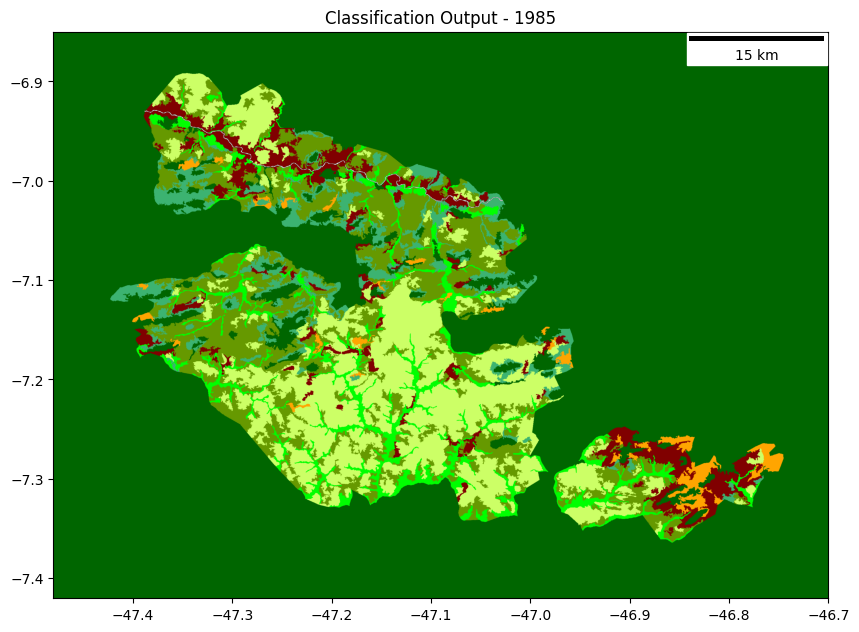

In [ ]:
# Create the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

rsgislib.tools.mapping.create_thematic_raster_map(ax, out_cls_img)
ax.title.set_text("Classification Output - 1985")

#### Visualise Subsets

In [ ]:
cls_info = rsgislib.tools.plotting.create_legend_info_dict(
    out_cls_img,
    cls_names_col="class_names",
    use_title_case=True,
    underscore_to_space=True,
)

cls_info

{'Ce Aberto': (204, 255, 102, 255),
 'Ce Denso': (102, 153, 0, 255),
 'Ce Rupestre': (128, 0, 0, 255),
 'Ced Altitude': (0, 102, 0, 255),
 'Ced Planicie': (60, 179, 113, 255),
 'Mat Galeria': (0, 255, 0, 255),
 'Mosaic Agri Past': (255, 165, 0, 255)}

In [ ]:
#BBOX
bbox_test = rsgislib.imageutils.get_img_bbox(input_img)
bbox_test

[-47.48009501602367,
 -46.699908191765864,
 -7.420263909884072,
 -6.849743872939764]

Image Data Size: 2895 x 2115
Image Data Size: 2895 x 2115


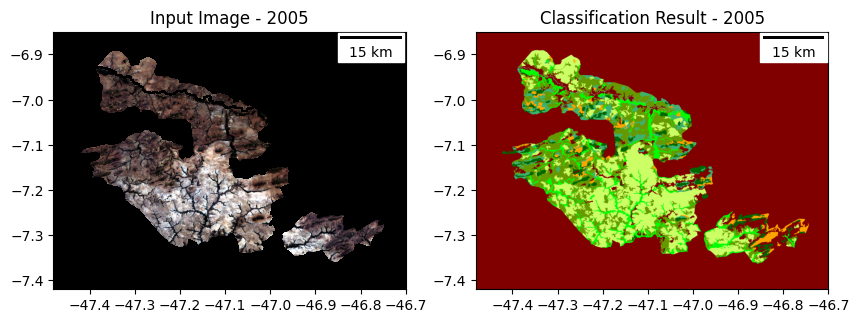

In [ ]:
# Define a bbox for the subset to be displayed
sub_img_bbox = [-47.48, -46.70, -7.42, -6.85] #xmin, xmax, ymin, ymax
#sub_img_bbox = [-47.1, -46.8, -7.2, -6.9]

#fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8), sharey=False)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10), sharey=False)

# Add the spectral image to the axis
rsgislib.tools.mapping.create_raster_img_map(
    ax1,
    input_img,
    img_bands=[9, 8, 7],
    img_stch=rsgislib.IMG_STRECTH_CUMULATIVE,
    bbox=sub_img_bbox,
    show_scale_bar=True,
)
ax1.title.set_text("Input Image - 2005")

# Add the classification to the second axis.
rsgislib.tools.mapping.create_thematic_raster_map(ax2, out_cls_img, bbox=sub_img_bbox)
ax2.title.set_text("Classification Result - 2005")

#rsgislib.tools.plotting.create_legend_img_mpl_ax(ax3, legend_info=cls_info, n_cols=2)
#ax3.title.set_text("Legenda")

### 2.4 Matriz de confusão e Validação

#### Confusion Matrix

In [ ]:
input_img

'/content/drive/MyDrive/00_vegetation_data/data/raster/1995/stack_pncm_1995_clip_norm_linear.tif'

In [ ]:
# Define Base Validação

class_img = '/content/drive/MyDrive/00_vegetation_data/data/raster/1985/result_class/pncm_1985_classificada.kea'
#class_img = '/content/classific_results/pncm_2005_classificada.kea'
#output_file = '/content/drive/MyDrive/00_vegetation_data/data/raster/2022/result_class/pncm_2022_classificada.txt'
#in_msk_img = '/content/drive/MyDrive/00_vegetation_data/data/raster/2022/result_segs/meanseg_2022_90-400.kea'

#out_cls_dir = "/content/classific_results/"

####Create Output Directory

In [ ]:
# Create Output Directory for Stats
out_stats_dir = "acc_stats"
if not os.path.exists(out_stats_dir):
    os.mkdir(out_stats_dir)

#### Carregando e visualizando dados de validação

Image Data Size: 2895 x 2117


<Axes: >

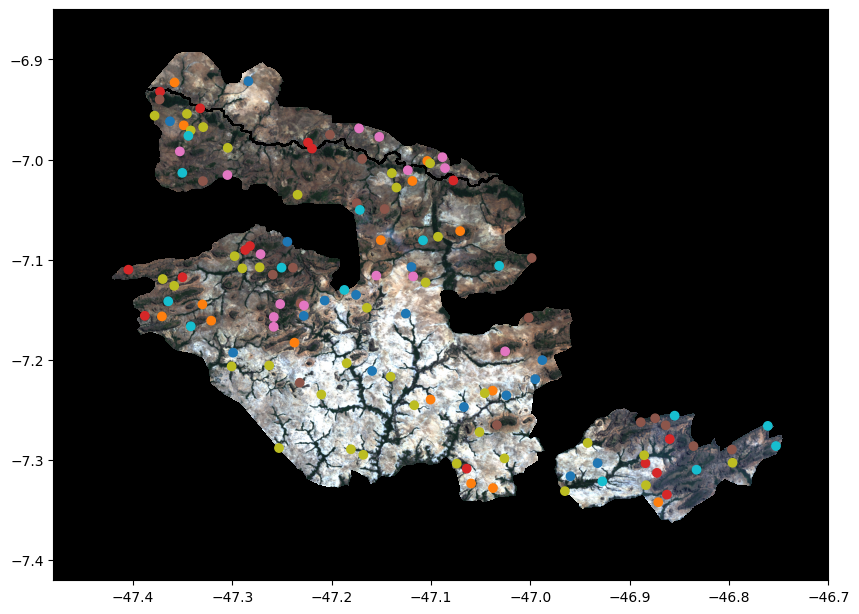

In [ ]:
#pts_val_file = "/content/drive/MyDrive/00_vegetation_data/data/shp/1985/amostras_pontos/amostras_1985_all.geojson"
#vec_lyr_pts_val = "amostras_1985_all"

pts_val_file = "/content/drive/MyDrive/00_vegetation_data/data/shp/1985/amostra_valid/valid_point_1985.geojson"
vec_lyr_pts_val = "valid_point_1985"


# Read image data
img_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    input_img, bands=[9, 8, 7]
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_data_strch = rsgislib.tools.plotting.stdev_stretch_np_arr(img_data, no_data_val=0.0)

# Create a plot using the matplotlib library
fig, ax = plt.subplots(figsize=(10, 10))
# Add the stretched image data to the plot and define the spatial
# extent so the axis labels are the coordinates.
ax.imshow(img_data_strch, extent=img_coords)

# Read points to geopandas dataframe
points_gdf = gpd.read_file(pts_val_file)
# Plot the plots over the image data
# Note. Points are randomly coloured by reference class
points_gdf.plot(ax=ax, column='class_name')

In [ ]:
# Rodando interpolação dos dados (classificado e validação)
rsgislib.classification.pop_class_info_accuracy_pts(
    input_img=class_img,
    vec_file=pts_val_file,
    vec_lyr=vec_lyr_pts_val,
    rat_class_col="class_names", #nome da coluna de classes no raster classificado
    vec_class_col="val_points", #nome da coluna com as classes de validação
    vec_ref_col=None,
    vec_process_col=None,
)

In [ ]:
# 6.1 What has changed in the attribute table?
#Visualizando tabela de atributos
points_gdf = gpd.read_file(pts_val_file)
points_gdf

id        class_name        val_points                    geometry
0    1.0         ce_aberto         ce_aberto  POINT (-46.98798 -7.20034)
1    1.0         ce_aberto         ce_aberto  POINT (-47.22812 -7.15612)
2    1.0         ce_aberto         ce_aberto  POINT (-46.99510 -7.21937)
3    1.0         ce_aberto         ce_aberto  POINT (-46.93234 -7.30327)
4    1.0         ce_aberto         ce_aberto  POINT (-47.29927 -7.19294)
..   ...               ...               ...                         ...
123  7.0  mosaic_agri_past      ced_planicie  POINT (-47.17167 -7.05026)
124  7.0  mosaic_agri_past  mosaic_agri_past  POINT (-47.10808 -7.08065)
125  7.0  mosaic_agri_past      ced_planicie  POINT (-47.35040 -7.01327)
126  7.0  mosaic_agri_past      ced_altitude  POINT (-47.25047 -7.10796)
127  7.0  mosaic_agri_past      ced_altitude  POINT (-46.85478 -7.25582)

[128 rows x 4 columns]

#####Filter Valid Points:

Some classifiers can produce no data regions and if those intersect with reference points then an error will occur when calculating the accuracy statistics so we need to remove those which we will do using geopandas. For points where there is no class (i.e., no data) in the input classification then the value "NA" is outputted into the attribute table and it is rows with an "NA" value that we want to remove.

In [ ]:
vec_refpts_vld_file = pts_val_file
vec_refpts_vld_lyr = vec_lyr_pts_val
points_gdf = points_gdf.drop(points_gdf[points_gdf["val_points"] == "NA"].index)
points_gdf.to_file(vec_refpts_vld_file, driver="GeoJSON")
points_gdf

id        class_name        val_points                    geometry
0    1.0         ce_aberto         ce_aberto  POINT (-46.98798 -7.20034)
1    1.0         ce_aberto         ce_aberto  POINT (-47.22812 -7.15612)
2    1.0         ce_aberto         ce_aberto  POINT (-46.99510 -7.21937)
3    1.0         ce_aberto         ce_aberto  POINT (-46.93234 -7.30327)
4    1.0         ce_aberto         ce_aberto  POINT (-47.29927 -7.19294)
..   ...               ...               ...                         ...
123  7.0  mosaic_agri_past      ced_planicie  POINT (-47.17167 -7.05026)
124  7.0  mosaic_agri_past  mosaic_agri_past  POINT (-47.10808 -7.08065)
125  7.0  mosaic_agri_past      ced_planicie  POINT (-47.35040 -7.01327)
126  7.0  mosaic_agri_past      ced_altitude  POINT (-47.25047 -7.10796)
127  7.0  mosaic_agri_past      ced_altitude  POINT (-46.85478 -7.25582)

[128 rows x 4 columns]

In [ ]:
#clumps='/content/classific_results/pncm_1985_classificada_withseg.kea'
#pyramids=True
#colourtable=True
#rastergis.pop_rat_img_stats(clumps, colourtable, pyramids)

In [ ]:
#out_json_file = os.path.join(out_stats_dir, "stats_valid_class_1985.json")
#out_csv_file = os.path.join(out_stats_dir, "stats_valid_class_1985.csv")
out_json_file = '/content/drive/MyDrive/00_vegetation_data/data/analise_acuracia/1985/stats_valid_class_1985.json'
out_csv_file = '/content/drive/MyDrive/00_vegetation_data/data/analise_acuracia/1985/stats_valid_class_1985.csv'


classaccuracymetrics.calc_acc_ptonly_metrics_vecsamples(
    vec_file=pts_val_file,
    vec_lyr=vec_lyr_pts_val,
    ref_col="class_name",
    cls_col="val_points",
    out_json_file=out_json_file,
    out_csv_file=out_csv_file)


{'ce_aberto': {'precision': 0.7647058823529411,
  'recall': 0.8125,
  'f1-score': 0.787878787878788,
  'support': 16},
 'ce_denso': {'precision': 0.4444444444444444,
  'recall': 0.5333333333333333,
  'f1-score': 0.4848484848484848,
  'support': 15},
 'ce_rupestre': {'precision': 0.6923076923076923,
  'recall': 0.6,
  'f1-score': 0.6428571428571429,
  'support': 15},
 'ced_altitude': {'precision': 0.5,
  'recall': 0.6666666666666666,
  'f1-score': 0.5714285714285715,
  'support': 18},
 'ced_planicie': {'precision': 0.23529411764705882,
  'recall': 0.26666666666666666,
  'f1-score': 0.25,
  'support': 15},
 'mat_galeria': {'precision': 0.8235294117647058,
  'recall': 0.8,
  'f1-score': 0.8115942028985507,
  'support': 35},
 'mosaic_agri_past': {'precision': 0.8,
  'recall': 0.2857142857142857,
  'f1-score': 0.4210526315789473,
  'support': 14},
 'accuracy': 0.609375,
 'macro avg': {'precision': 0.6086116497881203,
  'recall': 0.5664115646258503,
  'f1-score': 0.5670942602129265,
  'suppo

In [ ]:
cls_acc_stats_dict = rsgislib.tools.utils.read_json_to_dict(out_json_file)
pprint.pprint(cls_acc_stats_dict)

{'accuracy': 0.609375,
 'accuracy_conf_interval': [0.07072308506239096,
                            0.08452271141602821,
                            0.1004785293874213,
                            0.11125948747620042],
 'bal_accuracy_score': 0.5664115646258503,
 'ce_aberto': {'f1-score': 0.787878787878788,
               'precision': 0.7647058823529411,
               'recall': 0.8125,
               'support': 16},
 'ce_denso': {'f1-score': 0.4848484848484848,
              'precision': 0.4444444444444444,
              'recall': 0.5333333333333333,
              'support': 15},
 'ce_rupestre': {'f1-score': 0.6428571428571429,
                 'precision': 0.6923076923076923,
                 'recall': 0.6,
                 'support': 15},
 'ced_altitude': {'f1-score': 0.5714285714285715,
                  'precision': 0.5,
                  'recall': 0.6666666666666666,
                  'support': 18},
 'ced_planicie': {'f1-score': 0.25,
                  'precision': 0.235294117647

In [ ]:
print("Overall Accuracy: {}".format(cls_acc_stats_dict["accuracy"]))
print("Macro F1 Score: {}".format(cls_acc_stats_dict["macro avg"]["f1-score"]))
print("Area Weighted F1 Score: {}".format(
            cls_acc_stats_dict["weighted avg"]["f1-score"]))
print( "Kappa: {}".format(cls_acc_stats_dict['cohen_kappa']))

Overall Accuracy: 0.609375
Macro F1 Score: 0.5670942602129265
Area Weighted F1 Score: 0.6082647910227643
Kappa: 0.5328467153284672


## Referências

- Introduction to geobr (Python): https://ipeagit.github.io/geobr/articles/python-intro/py-intro-to-geobr.html
- Artigo Shepherd et al 2019 (Segmentador da biblioteca RSGISLib): https://www.mdpi.com/2072-4292/11/6/658#B42-remotesensing-11-00658
- Documentação: http://rsgislib.org/rsgislib_segmentation.html
- Turoriais RSGISLib GitHub: https://github.com/remotesensinginfo/rsgislib-tutorials
- GitHub: https://github.com/remotesensinginfo/rsgislib

- Scikit-image: https://scikit-image.org

- Biblioteca RSGISLib (Repositório): https://anaconda.org/conda-forge/rsgislib

- Landsat Collections:
  - https://www.remote-research.org/sat/understanding-landsat-collections-levels-and-tiers-which-do-i-use/
  - https://yceo.yale.edu/landsat-collections#:~:text=They%20have%20precision%20terrain%20processing%20and%20have%20been,and%20obscuring%20ground%20control%20points%20within%20the%20scenes.

- Collection of custom scripts: Custom scripts are a piece of Javascript code, used to visualize satellite imagery and to control what values the Sentinel Hub services will return.
  - https://custom-scripts.sentinel-hub.com/custom-scripts/

- Sentinel-Hub
  - https://custom-scripts.sentinel-hub.com/custom-scripts/

- Correlação de bandas:
  - https://github.com/Gustavoohs/PDIcomPython/blob/master/Posts/Correlacao_bandas.ipynb

- Spatial Clustering (Classificação com os dados climáticos
  - https://kazumatsuda.medium.com/spatial-clustering-fa2ea5d035a3

In [ ]:
# Acessando uma página web
from IPython.display import IFrame
IFrame(src= 'https://scikit-image.org', width=1000, height=600)

In [ ]:
from IPython.display import IFrame
IFrame(src='https://www.usgs.gov/landsat-missions/landsat-5', width=1000, height=600)

In [ ]:
from IPython.display import IFrame
IFrame(src='https://www.geo.fu-berlin.de/en/v/geo-it/gee/2-monitoring-ndvi-nbr/2-1-basic-information/index.html', width=1000, height=600)